In [11]:
import sys
import os, glob
import numpy as np
import subprocess
import nibabel
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pltn

In [12]:
# not necessary through available files
sys.path.append('/Scripts/')
import mm_helpers

In [13]:
# not necessary through available files
import rc_helpers
import rc_GetInfoFromDb

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'tri', 'number', 'copy', 'cond']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
serie='full'
norm='0'
cond='179'
atlas='atlas_complete_GM'
paired='1'
resi=0
matrices='ZpartialCorrelation'
norm2='subject'
method='_ledoit_wolf'
movement=False

In [16]:
#define the data
if cond=='179':
    number=np.int(cond)
    data=['/fMRI_RS/SUBJECT/matrices/preprocessing.feat/times_series/ICA_AROMA_nonaggr_nr_hp_atlas_subcort_cerebellum_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160.txt',
            '/fMRI_STOP/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_atlas_subcort_cerebellum_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160.txt',
            '/fMRI_REWARD/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_atlas_subcort_cerebellum_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160.txt',
            '/fMRI_WM/SUBJECT/matrices.feat/nuissance/denoised_func_data_nonaggr/times_series/denoised_func_data_nonaggr_hp_atlas_subcort_cerebellum_1mm_4D_warped_th_reg_'+matrices+''+method+'_149_152_155_158_159_160.txt',
            ]
    NeuroIMAGE=['RS','STOP','REWARD','WM']
    fold='BS_Control'+matrices+'_LW'
    fold='paired_'+fold

if atlas=='atlas_complete_GM':
    for i in range(len(data)):
        data[i]=data[i].replace('atlas_subcort_cerebellum','atlas_complete_GM')
    fold=fold+'withoutWM'

# select and check healthy subjects
suj=[np.unique([mm_helpers.find_subject(i,'NeuroIMAGE') for i in glob.glob(j.replace('SUBJECT','*').replace('CONDITION','*'))]) for j in data]
#file available
np.save('/subject_initial',suj)#file available

selec=len(NeuroIMAGE)
allinfo=[dict() for t in range(selec)]
for t in range(selec):
    for s in suj[t]:
        allinfo[t].update({s : {s:s,'run':[]}})


    allinfo[t]=rc_helpers.selectControl(allinfo[t])
    allinfo[t]=rc_helpers.check_movers(allinfo[t])
        
    suj[t]=sorted(allinfo[t].keys())
#file available
np.save('/subject',suj)


#get behavioural value
if norm=='0':
    fold=fold+'/notNorm'


if norm2=='subject':
    fold=fold+'_subjectNorm'


423
229
['19-222-10529', '19-167-10288', '19-832-8099', '98-335-30149', '19-90-1150', '19-59-1066', '19-136-10151', '98-154-10229', '19-831-8096', '19-51-0012', '19-227-10551']
410
235
['98-335-30149', '19-90-1150', '98-535-1449', '19-96-1161', '19-136-10152', '19-136-10151', '19-260-10700', '98-520-1386', '19-93-1156', '19-259-10694', '19-259-10695']
479
248
['98-530-1426', '19-832-8099', '98-335-30149', '98-535-1448', '19-78-1111', '19-96-1161', '98-537-1460', '19-259-10694', '98-154-10229', '19-831-8096', '19-51-0012', '19-227-10551']
461
260
['98-530-1426', '19-832-8099', '19-90-1150', '19-59-1066', '19-96-1161', '19-136-10152', '98-537-1460', '19-259-10694', '19-93-1156', '19-259-10695', '19-831-8096', '19-51-0012', '19-227-10551']


In [18]:
#create task pairing
Tpair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
if paired=='1' or movement==True:
    indexPopTpair=[[] for i in range(len(Tpair))]
    for i in range(len(Tpair)):
        try:
            indexPopTpair[i]=[[j for j,e in enumerate(suj[Tpair[i][0]]) if e in suj[Tpair[i][1]]],[np.where(suj[Tpair[i][1]]==e)[0][0] for e in suj[Tpair[i][0]] if e in suj[Tpair[i][1]]]]
        except:
            indexPopTpair[i]=[[j for j,e in enumerate(suj[Tpair[i][0]]) if e in suj[Tpair[i][1]]],[suj[Tpair[i][1]].index(e) for e in suj[Tpair[i][0]] if e in suj[Tpair[i][1]]]]


In [19]:
myquery2= """SELECT `Subject`,`age` FROM `Phenotype_info`"""
allinfo_age = rc_GetInfoFromDb.get_query(myquery2,['subject','age'],"neuroimage")
#file available
np.save('/allinfo_age',allinfo_age)

myquery2= """SELECT `Subject`,`Gender` FROM `Phenotype_info`"""
allinfo_gender = rc_GetInfoFromDb.get_query(myquery2,['subject','gender'],"neuroimage")
#file available
np.save('/allinfo_gender',allinfo_gender)


queryT = "SELECT `subject_number`,`SeriesNumber`,`ScanProtocol`,`n_tot_ICs`,`n_incl_ICs`  FROM `MRI_series_info` "
allinfo_aroma=rc_GetInfoFromDb.get_query(queryT, ['subject','sn','sp','tot','in'], 'neuroimage', True)
for k in allinfo_aroma.keys():
    try: 
        
        if np.float(allinfo_aroma[k]['tot'])==0.0:
            allinfo_aroma[k]['ratio']=0.0
        else:
            allinfo_aroma[k]['ratio']=np.float(allinfo_aroma[k]['in'])/np.float(allinfo_aroma[k]['tot'])
    except:
        
        del allinfo_aroma[k]
#file available
np.save('/allinfo_aroma',allinfo_aroma)

queryT = "SELECT `subject_number`,`SeriesNumber`,`ScanProtocol`,`rmsFD_Jenkinson`  FROM `MRI_series_info` "
allinfo_rms=rc_GetInfoFromDb.get_query(queryT, ['subject','sn','sp','jen'], 'neuroimage', True)
#file available
np.save('/allinfo_rms',allinfo_rms)

queryT = "SELECT `subject_number`,`TR_fMRI`,`TR_rsfMRI`  FROM `MRI_session_info` "
allinfo_TR=rc_GetInfoFromDb.get_query(queryT, ['subject','tr','trrs'], 'neuroimage', True)
#file available
np.save('/allinfo_TR',allinfo_TR)

In [20]:
#load normalized Z partial correlation matrices and subject characteristics
Upmatrices=[[] for t in range(len(NeuroIMAGE))]
UpmatricesREST=[[] for t in range(len(NeuroIMAGE))]
age=[[] for t in range(len(suj))]
gender=[[] for t in range(len(suj))]
edgefrac=[[] for t in range(len(suj))]
rms=[[] for t in range(len(suj))]
ncompAROMA=[[] for t in range(len(suj))]
tr=[[] for t in range(len(suj))]
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1

for t in range(len(NeuroIMAGE)):
    prov2=[]
    for s in suj[t]:
        dat=glob.glob(data[t].replace('SUBJECT',s))
        for f in dat:
            do=1
            if norm=='0' and paired=='1' and t!=0:
                if s in suj[0]:
                    prov=np.loadtxt(f)
                    provrest=np.loadtxt(glob.glob(data[0].replace('SUBJECT',s))[0])
                else:
                    do=0
            else:
                prov=np.loadtxt(f)
            if do==1:
                #normalization
                
                if norm=='subject' or norm2=='subject':
                    #mixture modelling
                    prov=np.loadtxt(f.replace('.txt','NORM.txt'))
                    if norm=='0' and paired=='1' and t!=0:
                        provrest=np.loadtxt((glob.glob(data[0].replace('SUBJECT',s))[0]).replace('.txt','NORM.txt'))
                if norm=='0' and paired=='1' and t!=0:
                    prov=prov-provrest
                    UpmatricesREST[t]+=[provrest]
                if norm=='0' and paired=='1' and t==0:
                    UpmatricesREST[t]+=[prov]
                Upmatrices[t]+=[prov]
                age[t]+=[np.float(allinfo_age[k]['age']) for k in allinfo_age.keys() if allinfo_age[k]['subject']==s]
                gender[t]+=[allinfo_gender[k]['gender'] for k in allinfo_age.keys() if allinfo_age[k]['subject']==s]
                if t!=0:
                    rms[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='fMRI_'+NeuroIMAGE[t])])]
                    ncompAROMA[t]+=[np.mean([np.float(allinfo_aroma[k]['ratio']) for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='fMRI_'+NeuroIMAGE[t])])]
                    fprov3=glob.glob('/fMRI_'+NeuroIMAGE[t]+'/'+s+'/*_fMRI_'+NeuroIMAGE[t]+'.feat/classification_overview.txt')
                    tr[t]+=[allinfo_TR[k]['tr'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
                if t==0:
                    rms[t]+=[np.mean([allinfo_rms[k]['jen'] for k in allinfo_rms.keys() if (allinfo_rms[k]['subject']==s) & (allinfo_rms[k]['sp']=='rs_fMRI')])]
                    ncompAROMA[t]+=[np.mean([np.float(allinfo_aroma[k]['ratio']) for k in allinfo_aroma.keys() if (allinfo_aroma[k]['subject']==s) & (allinfo_aroma[k]['sp']=='rs_fMRI')])]
                    tr[t]+=[allinfo_TR[k]['trrs'] for k in allinfo_TR.keys() if allinfo_TR[k]['subject']==s]
                    fprov3=glob.glob('/rfMRI/'+s+'/*_rs_fMRI/preprocessing/ICA_AROMA/IC_classification_overview.txt')
                fprov2=[]
                for of in fprov3:
                    fprov=open(of).read().split()
                    fprov=np.reshape(fprov[9:],((len(fprov)-9)/6,6))
                    for l in range(len(fprov)):
                        if fprov[l][1]=='True':
                            fprov2+=[np.float(fprov[l][3])]
                edgefrac[t]+=[np.sum(fprov2)]

    
if not os.path.exists('/'+fold+'/'+np.str(number)+'/dist_pdf'):
    os.makedirs('/'+fold+'/'+np.str(number)+'/dist_pdf')

#atlas details
number2=11
net=['visual1','motor','fronto-temp','visual2','R_attention','DMN','auditory','L_attention','cingulum','sub-cort','cereb']
group=[0 for i in range(20)]+[1 for i in range(11)]+[2 for i in range(22)]+[3 for i in range(22)]+[4 for i in range(18)]+[5 for i in range(8)]+[6 for i in range(18)]+[7 for i in range(13)]+[8 for i in range(7)]+[9 for i in range(17)]+[10 for i in range(23)]
    
Nareas=[20,11,22,22,18,8,18,13,7,17,23]
groupnet=[' ' for i in range(len(group))]#
groupnet[Nareas[0]/2]='visual1'
j=1
for i in range(len(group)):
    if i>0 and group[i] != group[i - 1]:
        groupnet[i+Nareas[j]/2]=net[group[i]]
        j+=1



In [21]:
#demographic information
print [len(age[t]) for t in range(4)]
print [np.mean(age[t]) for t in range(4)]
print [np.std(age[t]) for t in range(4)]

[218, 111, 123, 144]
[16.672889908256881, 16.797297297297298, 16.537642276422762, 16.46125]
[3.4573058393464247, 3.485814999237856, 3.1826016052476467, 3.2580570801476143]


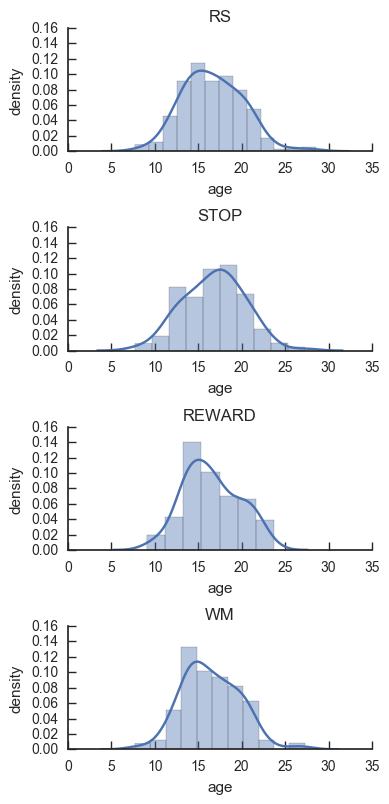

In [22]:
#supplementary material figure 1
plt.figure(figsize=(4,8))
sns.set_style('white')
sns.set_style('ticks')
plt.tick_params(direction='in')
sns.despine()
plt.tight_layout()

for i in range(len(NeuroIMAGE)):
    plt.subplot(4,1,i+1)
    sns.distplot(age[i])#,hist=False)
    plt.tight_layout()
    plt.ylim([0,0.16])
    plt.xlim([0,35])
    plt.title(NeuroIMAGE[i])
    plt.xlabel('age')
    plt.ylabel('density')
    
    sns.set_style('ticks')

    plt.tick_params(direction='in')
    sns.despine()

plt.savefig('/'+fold+'/'+np.str(number)+'/distage.pdf')
plt.show()

/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:267: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


-0.328496835311
-0.350238628793


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:267: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


-0.366611063659


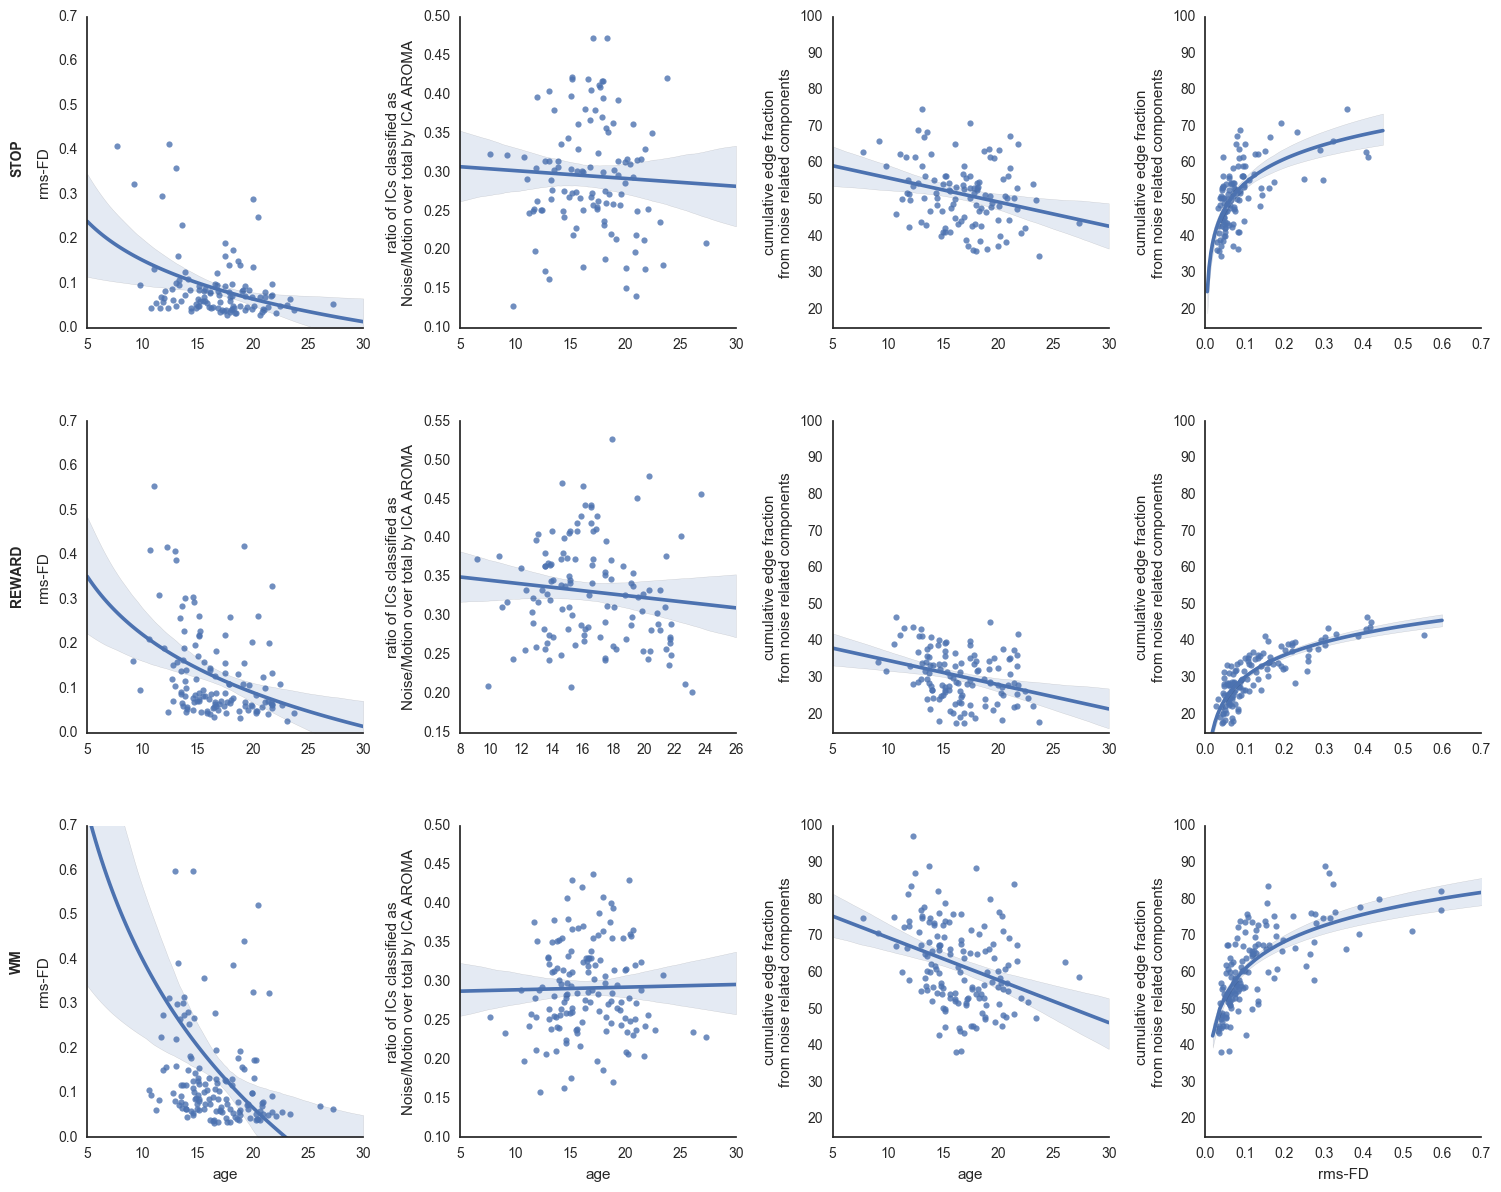

In [23]:
## link between age and rms
#supplementary material figure 2
plt.figure(figsize=(15,12))
sns.set_style('white')
for i in range(1,len(NeuroIMAGE)):
    
    plt.subplot(3,4,1+(i-1)*4)
    plt.text(-2,0.4,NeuroIMAGE[i],fontweight='bold',rotation=90)
    plt.ylabel("\nrms-FD")
    plt.ylim([0,0.7])
    if i==3:
        plt.xlabel('age')
    plt.xlim([5,30])
    sns.regplot(np.array(age[i]),np.array(rms[i]),logx=True)
    
    plt.subplot(3,4,2+(i-1)*4)
    plt.ylabel("ratio of ICs classified as\nNoise/Motion over total by ICA AROMA")
    if i==3:
        plt.xlabel('age')
    sns.regplot(np.array(age[i]),np.array(ncompAROMA[i]))
    plt.subplot(3,4,3+(i-1)*4)
    plt.xlim([5,30])
    plt.ylabel("cumulative edge fraction\nfrom noise related components")
    plt.ylim([15,100])
    if i==3:
        plt.xlabel('age')
    sns.regplot(np.array(age[i]),np.array(edgefrac[i]))
    plt.subplot(3,4,4+(i-1)*4)
    plt.ylabel("cumulative edge fraction\nfrom noise related components")
    plt.ylim([15,100])
    if i==3:
        plt.xlabel('rms-FD')
    sns.regplot(np.array(rms[i]),np.array(edgefrac[i]),logx=True)#order=2)
    plt.xlim([0,0.7])
    
    print np.corrcoef(age[i],rms[i])[0][1]
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
sns.despine()
plt.savefig('/'+fold+'/'+np.str(number)+'/reviewmovement.pdf')
plt.show()

# reordering and standardization 

In [24]:
def reordering(mat):
    import scipy
    if len(mat)!=179:
        print 'ordering not adequate'
        return
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    order=[]
    
    for i in range(len(UpArea)-1):
        print i

        prov=(mat[UpArea[i]:UpArea[i+1],UpArea[i]:UpArea[i+1]])+int(1-np.min(mat))#np.abs(mat[UpArea[i]:UpArea[i+1],UpArea[i]:UpArea[i+1]])#
        Q=-prov
        t=np.zeros(prov.shape)
        for j in range(len(prov)):
            Q[j,j]=np.sum(prov[j][[g for g in range(len(prov)) if g!=j]],0)
            t[j][j]=1./np.sqrt(np.sum(prov[j]))
        D=np.dot(np.dot(t,Q),t)
        v=scipy.linalg.eig(D)[1][:,1]
        v2=np.dot(t,v)
        order+=[UpArea[i]+np.argsort(v2)]
    return order

In [26]:
#reordering of areas inside each network and reordering of networks, for visualization purposes
orderRest=reordering(np.mean(Upmatrices[0],0))
UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
order=np.array([0,3,6,1,2,4,7,5,8,9,10])
orderlevel1=order
orderrest2=np.concatenate([np.concatenate(orderRest,0)[UpArea[order[i]]:UpArea[order[i]+1]] for i in range(len(order))],0)

net=[net[i] for i in order]
group=[group[i] for i in orderrest2]
groupnet=np.concatenate([groupnet[UpArea[order[i]]:UpArea[order[i]+1]] for i in range(len(order))],0)
UpArea=[UpArea[i] for i in order]



0
1
2
3
4
5
6
7
8
9
10


In [27]:
#reordering
if paired=='1' and norm=='0':    
    for t in range(len(NeuroIMAGE)):
        if t!=0:
            suj[t]=[suj[t][y] for y in indexPopTpair[t-1][1]]
    
        for s in range(len(Upmatrices[t])):
            Upmatrices[t][s]=Upmatrices[t][s][orderrest2,:]
            Upmatrices[t][s]=Upmatrices[t][s][:,orderrest2]


# group level selection

In [30]:
med2=np.ones((len(NeuroIMAGE),number,number))
p=np.triu_indices(number)
#mean across population
UpmatMean2=np.array([np.mean(np.array(Upmatrices[i]*np.sqrt(len(Upmatrices[i]))),0) for i in range(len(NeuroIMAGE))])
UpmatStd2=np.array([np.std(np.array(Upmatrices[i]*np.sqrt(len(Upmatrices[i]))),0) for i in range(len(NeuroIMAGE))])
UpmatZ=np.array([(UpmatMean2[i]-np.mean(UpmatMean2[i]))/np.std(UpmatMean2[i]) for i in range(len(NeuroIMAGE))])
med2[np.where(np.abs(UpmatZ)>=2.3)]=0.0


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# subject level selection

In [31]:
# subject level selection of edge
p=np.triu_indices(number,1)

Upmatselect=[[] for t in range(len(NeuroIMAGE))]
for t in range(len(NeuroIMAGE)):
    Upmatselect[t]=np.zeros((len(Upmatrices[t]),number,number))
    for s in range(len(Upmatrices[t])):
        [mprov,stdprov]=[np.mean(Upmatrices[t][s][p]),np.std(Upmatrices[t][s][p])]
        Upmatselect[t][s][np.where(np.abs((Upmatrices[t][s]-mprov)/stdprov)>2.3)]=1



In [32]:
#for the group selection (fingerprint)
provZ=np.array([UpmatZ[t] for t in range(1,4)])
provZ[np.where(np.abs(provZ)<=2.3)]=0
provZALL=np.abs(np.sign(provZ))
import copy
provZrest=copy.deepcopy(UpmatZ[0])
provZrest[np.where(np.abs(provZrest)<=2.3)]=0
provZrest=np.abs(np.sign(provZrest))

# age paper cross test
common
STOP 0.00341474808812
REWARD 0.135634573755
WM 0.157989920603


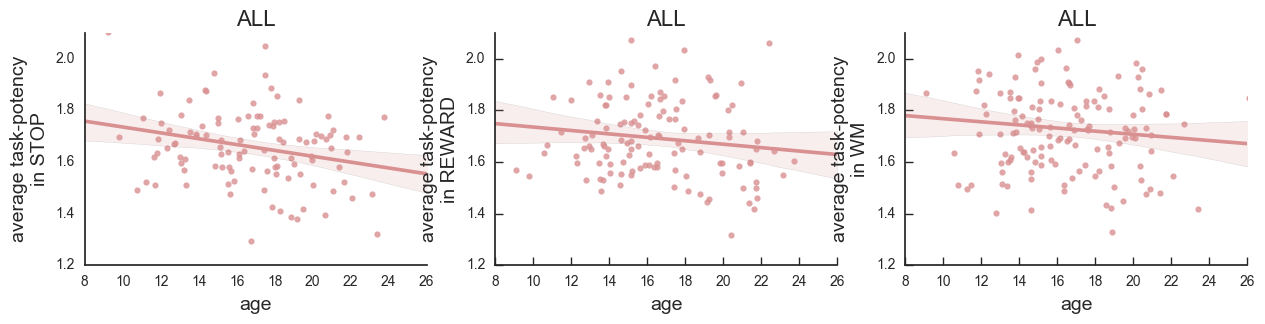

sensitive
STOP
STOP 0.026992873022 0.043823941099


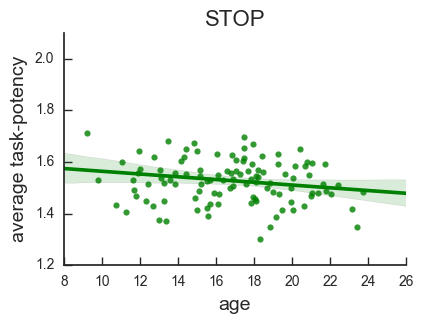

sensitive
REWARD
REWARD 0.118411727614 -0.0461102740079


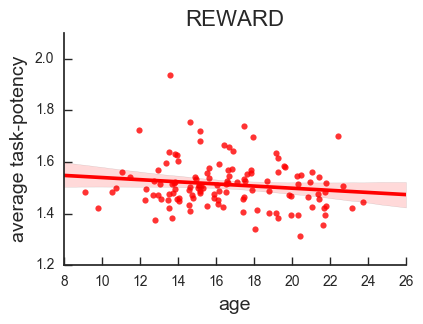

sensitive
WM
WM 0.0180220949345 0.0471866649561


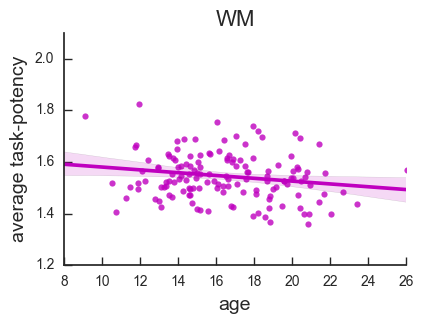

In [34]:
#figure 3
print '# age paper cross test'
import seaborn
import statsmodels.api as sm
c=['#d99091','#d99091','#d99091']
common=np.sum(np.abs(1-med2[1:]),0)
common[np.where(common!=3)]=0
common=np.sign(common)
sns.despine()

keeppval=[]

print 'common'
select=common
plt.figure(figsize=(15,3))
for t3 in range(1,4):
    test=np.zeros(300)
    test2=np.zeros(300)
    plt.subplot(1,3,t3)
    test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
    notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
    sns.regplot(x=np.array(age[0])[notnan],y=test[notnan],color=c[t3-1])
    results=sm.OLS((test[notnan]),sm.add_constant(age[0])[notnan],prepend=False).fit()
    print NeuroIMAGE[t3],results.t_test(np.identity(2)).pvalue[1]
    plt.xlim([8,26])
    plt.ylim([1.2,2.1])
    sns.despine()
    plt.ylabel('average task-potency\nin '+NeuroIMAGE[t3],fontsize=14)
    plt.xlabel('age',fontsize=14)
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.title('ALL',fontsize=16)
    keeppval+=[(results.t_test(np.identity(2)).pvalue)[1]]
plt.savefig('/'+fold+'/'+np.str(number)+'/common_EVOL.pdf')
plt.show()

c=['g','r','m']

for t in range(1,4):
    print 'sensitive'
    select=np.abs(1-med2[t])
        
    select=np.sign(select)

    print NeuroIMAGE[t]
    plt.figure(figsize=(15,3))
    for t3 in range(t,t+1):
        test=np.zeros(300)
        test2=np.zeros(300)
        plt.subplot(1,3,t3)
        test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
        test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
        notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
        sns.regplot(x=np.array(age[0])[notnan],y=test[notnan],color=c[t3-1])
        results=sm.OLS((test[notnan]),sm.add_constant(age[0])[notnan],prepend=False).fit()
        print NeuroIMAGE[t3],results.t_test(np.identity(2)).pvalue[1], np.corrcoef(test2[notnan],test[notnan])[0][1]
        plt.xlim([8,26])
        plt.ylim([1.2,2.1])
        sns.despine()
        plt.ylabel('average task-potency',fontsize=14)
        plt.xlabel('age',fontsize=14)
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        plt.title(NeuroIMAGE[t3],fontsize=16)
        if t==t3:
            keeppval+=[(results.t_test(np.identity(2)).pvalue)[1]]
            
    plt.savefig('/'+fold+'/'+np.str(number)+'/sensitive_'+NeuroIMAGE[t]+'_EVOL.pdf')
    plt.show()
    

# age paper cross test
common-> STOP
                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.737
Date:                Tue, 12 Dec 2017   Prob (F-statistic):            0.00384
Time:                        20:32:35   Log-Likelihood:                 65.106
No. Observations:                 111   AIC:                            -122.2
Df Residuals:                     107   BIC:                            -111.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.117
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.102
Time:                        20:32:35   Log-Likelihood:                 57.063
No. Observations:                 123   AIC:                            -106.1
Df Residuals:                     119   BIC:                            -94.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9167      0.101     18.963      0.0

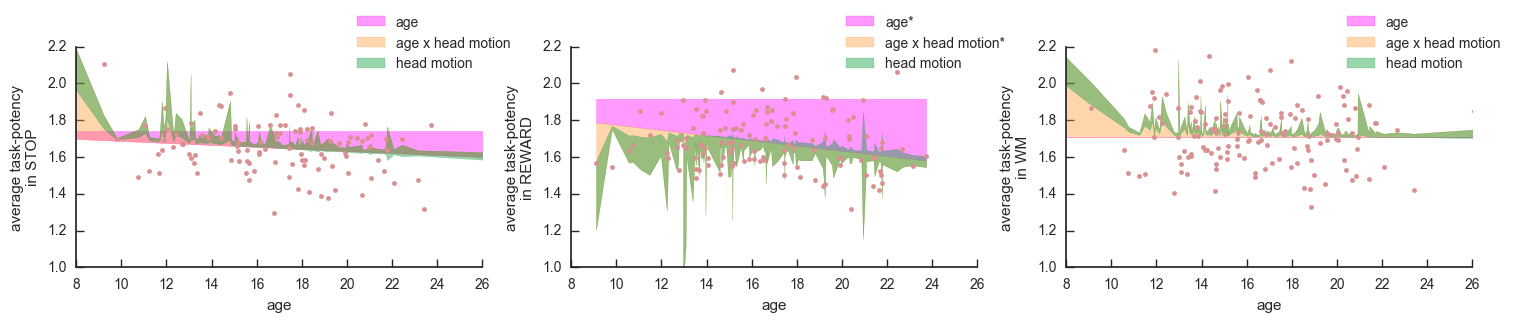

sensitive STOP -> STOP
                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.990
Date:                Tue, 12 Dec 2017   Prob (F-statistic):           0.000244
Time:                        20:32:37   Log-Likelihood:                 121.77
No. Observations:                 111   AIC:                            -235.5
Df Residuals:                     107   BIC:                            -224.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5056      0.

/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


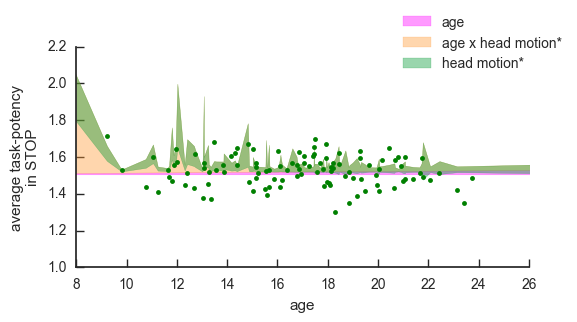

sensitive REWARD -> REWARD
                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.421
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.240
Time:                        20:32:38   Log-Likelihood:                 120.19
No. Observations:                 123   AIC:                            -232.4
Df Residuals:                     119   BIC:                            -221.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6222    

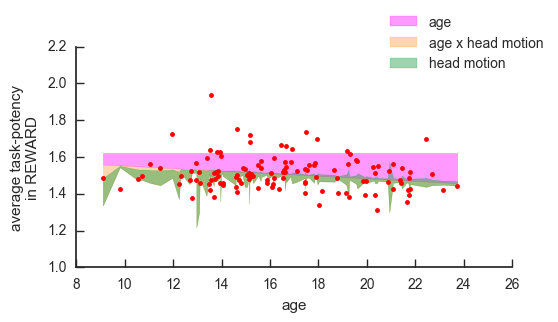

sensitive WM -> WM
                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.154
Date:                Tue, 12 Dec 2017   Prob (F-statistic):            0.00745
Time:                        20:32:39   Log-Likelihood:                 148.50
No. Observations:                 144   AIC:                            -289.0
Df Residuals:                     140   BIC:                            -277.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5605      0.048 

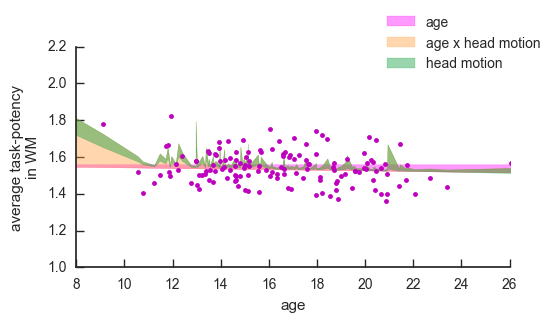

In [35]:
#supplementary material figure 3
print '# age paper cross test'
import seaborn
import patsy
import sklearn.metrics
import pandas
import statsmodels.formula.api as sm
c=['#d99091','#d99091','#d99091']
common=np.sum(np.abs(1-med2[1:]),0)
common[np.where(common!=3)]=0
common=np.sign(common)
sns.despine()

keeppval=[]


select=common
plt.figure(figsize=(15,3))
for t3 in range(1,4):
    print 'common->',NeuroIMAGE[t3]
    test=np.zeros(300)
    test2=np.zeros(300)
    plt.subplot(1,3,t3)
    test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
    notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
    
    dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':test[notnan]})
    results=sm.ols(formula='pot ~ mvt + age+age*mvt',data=dataframe).fit()
    print results.summary()
    print results.f_test([0,-2,1,1])
   
    plt.plot(np.array(age[0])[notnan],test[notnan],'.',c=c[t3-1])
    f='pot ~ mvt + age +age*mvt'
    y,X=patsy.dmatrices(f,dataframe,return_type='dataframe')
    ordersort=np.argsort(dataframe['age'])
    y1=((results.params*X)['age'][ordersort])
    y0=(results.params*X)['Intercept']
    y2=((results.params*X)['mvt'][ordersort])
    y3=((results.params*X)['age:mvt'][ordersort])
    
    plt.fill_between(dataframe['age'][ordersort],(y0)[ordersort],(y0+y1)[ordersort],color='#ff00ff',alpha=0.4,label='age'+('*')*((results.t_test(np.identity(4)).pvalue)[2]<0.05),interpolate=True)
    plt.fill_between(dataframe['age'][ordersort],(y0+y1)[ordersort],(y0+y1+y2)[ordersort],color='#ff9933',alpha=0.4,label='age x head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[3]<0.05),interpolate=True)
    plt.fill_between(dataframe['age'][ordersort],(y0+y1+y2)[ordersort],(y0+y1+y2+y3)[ordersort],color='#009933',alpha=0.4,label='head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[1]<0.05),interpolate=True)
    sns.despine()
    plt.ylabel('average task-potency\nin '+NeuroIMAGE[t3])
    plt.xlabel('age')
    plt.xlim([8,26])
    plt.ylim([1.0,2.2])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.legend(bbox_to_anchor=[1.1,1.2])
    plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/common_EVOL_A-AxM-M.pdf')
plt.show()            


c=['g','r','m']

for t in range(1,4):
    
    select=np.abs(1-med2[t])
        
    select=np.sign(select)
    plt.figure(figsize=(15,3))
    
    
    for t3 in range(t,t+1):
        print 'sensitive',NeuroIMAGE[t],'->',NeuroIMAGE[t3]
        test=np.zeros(300)
        test2=np.zeros(300)
        plt.subplot(1,3,t3)
        test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
        test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
        notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
        
        dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':test[notnan]})
        results=sm.ols(formula='pot ~ mvt + age+age*mvt',data=dataframe).fit()
        print results.summary()
        print results.f_test([0,-2,1,1])
        plt.plot(np.array(age[0])[notnan],test[notnan],'.',c=c[t3-1])
        f='pot ~ mvt + age +age*mvt'
        y,X=patsy.dmatrices(f,dataframe,return_type='dataframe')
        ordersort=np.argsort(dataframe['age'])
        y1=((results.params*X)['age'][ordersort])
        y0=(results.params*X)['Intercept']
        y2=((results.params*X)['mvt'][ordersort])
        y3=((results.params*X)['age:mvt'][ordersort])
        plt.fill_between(dataframe['age'][ordersort],(y0)[ordersort],(y0+y1)[ordersort],color='#ff00ff',alpha=0.4,label='age'+('*')*((results.t_test(np.identity(4)).pvalue)[2]<0.05),interpolate=True)
        plt.fill_between(dataframe['age'][ordersort],(y0+y1)[ordersort],(y0+y1+y2)[ordersort],color='#ff9933',alpha=0.4,label='age x head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[3]<0.05),interpolate=True)
        plt.fill_between(dataframe['age'][ordersort],(y0+y1+y2)[ordersort],(y0+y1+y2+y3)[ordersort],color='#009933',alpha=0.4,label='head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[1]<0.05),interpolate=True)
        sns.despine()
        plt.ylabel('average task-potency\nin '+NeuroIMAGE[t3])
        plt.xlabel('age')
        plt.xlim([8,26])
        plt.ylim([1.0,2.2])
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        plt.legend(bbox_to_anchor=[1.1,1.2])
        plt.tight_layout()
    plt.savefig('/'+fold+'/'+np.str(number)+'/sensitive_'+NeuroIMAGE[t]+'_EVOL_A-AxM-M.pdf')
    plt.show()
    select=np.sum(np.abs(1-med2[1:]),0)
    select[np.where(select!=1)]=0
    select=select*np.abs(1-med2[t])
    select=np.sign(select)


# age paper cross test
STOP WM
[  8.39671512e-58   1.62195521e-03] [ 1.78847192 -0.01039459]
[  4.43538693e-54   5.51719665e-02] [ 1.74432537 -0.00726147]
[  5.92515690e-64   5.97128539e-02] [ 1.78274626 -0.00664319]


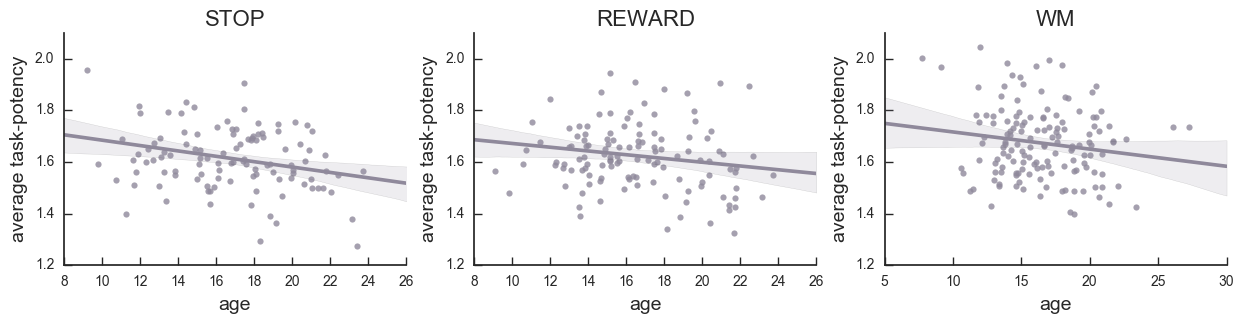

In [36]:
#figure 3
print '# age paper cross test'
import seaborn
import statsmodels.api as sm
common=np.sum(np.abs(1-med2[1:]),0)
common[np.where(common!=3)]=0
common=np.sign(common)
sns.despine()
sns.set_style("ticks")

keeppval=[]

for t in range(1,2):
    
    for t2 in range(3,4):
        
        if t!=t2:
            select=np.sum(np.abs(1-med2[[t,t2]]),0)
            select[np.where(select!=2)]=0
            select=np.sign(select)

            print NeuroIMAGE[t],NeuroIMAGE[t2]
            plt.figure(figsize=(15,3))
            c=['g','r','m']
            if t==1 and t2==3:
                c=['#8f899b','#8f899b','#8f899b']
            for t3 in range(1,4):
                plt.xlim([8,26])
                test=np.zeros(300)
                test2=np.zeros(300)
                plt.subplot(1,3,t3)
                test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
                test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
                notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
                sns.regplot(x=np.array(age[0])[notnan],y=test[notnan],color=c[t3-1])
                
                results=sm.OLS((test[notnan]),sm.add_constant(age[0])[notnan],prepend=False).fit()
                print results.t_test(np.identity(2)).pvalue, results.params
                
                plt.ylim([1.2,2.1])
                
                plt.title(NeuroIMAGE[t3],fontsize=16)
                
                keeppval+=[(results.t_test(np.identity(2)).pvalue)[1]]
                
                sns.despine()
                plt.ylabel('average task-potency',fontsize=14)
                plt.xlabel('age',fontsize=14)
                sns.set_style('ticks')
                plt.tick_params(direction='in')
            plt.savefig('/'+fold+'/'+np.str(number)+'/common_'+NeuroIMAGE[t]+'_'+NeuroIMAGE[t2]+'_EVOL.pdf')
            plt.show()
    

# age paper cross test, integrating movement
STOP WM -> STOP
                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     6.977
Date:                Tue, 12 Dec 2017   Prob (F-statistic):           0.000248
Time:                        20:32:43   Log-Likelihood:                 85.476
No. Observations:                 111   AIC:                            -163.0
Df Residuals:                     107   BIC:                            -152.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     5.047
Date:                Tue, 12 Dec 2017   Prob (F-statistic):            0.00251
Time:                        20:32:44   Log-Likelihood:                 80.690
No. Observations:                 123   AIC:                            -153.4
Df Residuals:                     119   BIC:                            -142.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8177      0.083     21.791      0.0

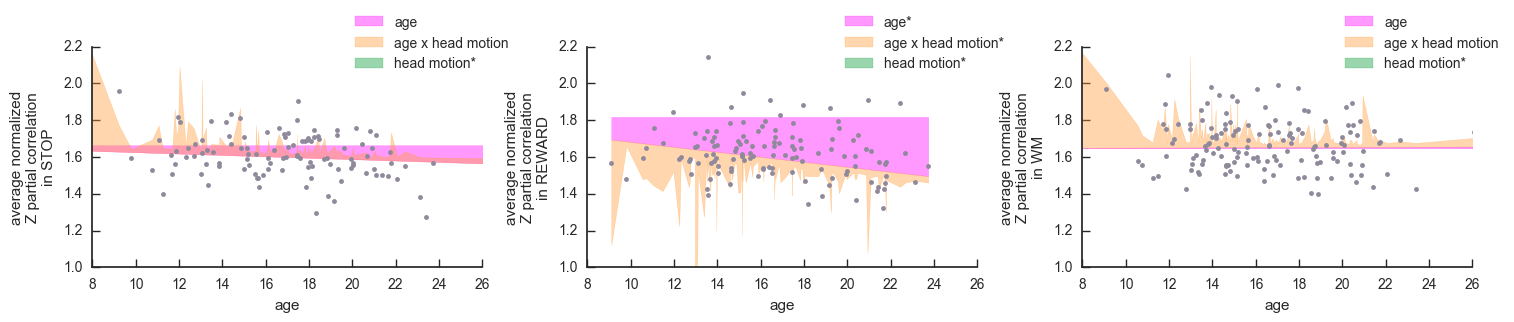

In [37]:
#supplementary material figure 3
print '# age paper cross test, integrating movement'
import seaborn
import pandas
import patsy
import statsmodels.formula.api as sm
common=np.sum(np.abs(1-med2[1:]),0)
common[np.where(common!=3)]=0
common=np.sign(common)
sns.despine()
sns.set_style("ticks")

keeppval=[]

for t in range(1,2):
    
    for t2 in range(3,4):
        
        if t!=t2:
            select=np.sum(np.abs(1-med2[[t,t2]]),0)
            select[np.where(select!=2)]=0
            select=np.sign(select)
            plt.figure(figsize=(15,3))
            c=['g','r','m']
            if t==1 and t2==3:
                c=['#8f899b','#8f899b','#8f899b']
            if t==1 and t2==2:
                c=['#DD3E86','#DD3E86','#DD3E86']
            if t==2 and t2==3:
                c=['#bc9b48','#bc9b48','#bc9b48']

            for t3 in range(1,4):
                print NeuroIMAGE[t],NeuroIMAGE[t2],'->',NeuroIMAGE[t3]
                
                test=np.zeros(300)
                test2=np.zeros(300)
                
                test[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
                test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
                notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
               
                dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':test[notnan]})
                results=sm.ols(formula='pot ~ mvt + age+ mvt*age',data=dataframe).fit()
                plt.subplot(1,3,t3)
                print results.summary()
                print results.f_test([0,-2,1,1])
                plt.plot(np.array(age[0])[notnan],test[notnan],'.',c=c[t3-1])
                f='pot ~ mvt + age +age*mvt'
                y,X=patsy.dmatrices(f,dataframe,return_type='dataframe')
                ordersort=np.argsort(dataframe['age'])
                y1=((results.params*X)['age'][ordersort])
                y0=(results.params*X)['Intercept']
                y2=((results.params*X)['mvt'][ordersort])
                y3=((results.params*X)['age:mvt'][ordersort])
                plt.fill_between(dataframe['age'][ordersort],(y0)[ordersort],(y0+y1)[ordersort],color='#ff00ff',alpha=0.4,label='age'+('*')*((results.t_test(np.identity(4)).pvalue)[2]<0.05),interpolate=True)
                plt.fill_between(dataframe['age'][ordersort],(y0+y1)[ordersort],(y0+y1+y2)[ordersort],color='#ff9933',alpha=0.4,label='age x head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[3]<0.05),interpolate=True)
                plt.fill_between(dataframe['age'][ordersort],(y0+y1+y2)[ordersort],(y0+y1+y2+y3)[ordersort],color='#009933',alpha=0.4,label='head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[1]<0.05),interpolate=True)
                sns.despine()
                plt.ylabel('average normalized\nZ partial correlation\nin '+NeuroIMAGE[t3])
                plt.xlabel('age')
                plt.xlim([8,26])
                plt.ylim([1.0,2.2])
                sns.set_style('ticks')
                plt.tick_params(direction='in')
                plt.legend(bbox_to_anchor=[1.1,1.2])
                plt.tight_layout()
            plt.savefig('/'+fold+'/'+np.str(number)+'/common_'+NeuroIMAGE[t]+'_'+NeuroIMAGE[t2]+'_EVOL_A-AxM-M.pdf')
            plt.show()
    

# age paper cross test
0


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


[  1.51488339e-110   9.42303518e-004] [ 2.1690186  -0.00962269] -0.00956756073596


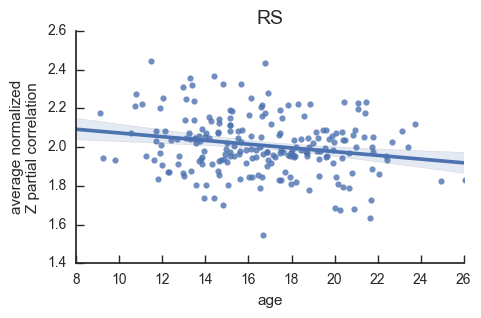

In [38]:
print '# age paper cross test'
import seaborn
import statsmodels.api as sm

sns.despine()

keeppval=[]

select=np.abs(1-med2[0])
plt.figure(figsize=(5,3))
for t3 in range(1):
    print t3
    test=np.zeros(300)
    test2=np.zeros(300)
    
    test=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
    notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
    sns.regplot(x=np.array(age[0])[notnan],y=test[notnan])
    results=sm.OLS((test[notnan]),sm.add_constant(age[0])[notnan],prepend=False).fit()
    print results.t_test(np.identity(2)).pvalue, results.params, np.corrcoef(test2[notnan],test[notnan])[0][1]
    plt.xlim([8,26])
    sns.despine()
    plt.ylabel('average normalized\nZ partial correlation')
    plt.xlabel('age')
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.title(NeuroIMAGE[t3],fontsize=14)
    keeppval+=[(results.t_test(np.identity(2)).pvalue)[1]]
plt.savefig('/'+fold+'/'+np.str(number)+'/REST_EVOL.pdf')
plt.show()


# age paper cross test integrating movement
0


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


                            OLS Regression Results                            
Dep. Variable:                    pot   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     8.695
Date:                Tue, 12 Dec 2017   Prob (F-statistic):           1.81e-05
Time:                        20:32:48   Log-Likelihood:                 117.44
No. Observations:                 218   AIC:                            -226.9
Df Residuals:                     214   BIC:                            -213.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0658      0.061     33.776      0.0

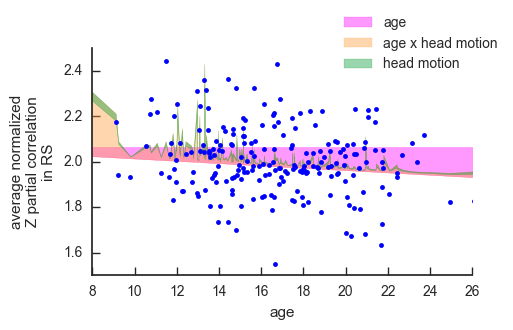

In [39]:
print '# age paper cross test integrating movement'
import seaborn
import statsmodels.formula.api as sm

c=['b','b','b']

sns.despine()

keeppval=[]


select=np.abs(1-med2[0])
plt.figure(figsize=(5,3))
for t3 in range(1):
    print t3
    test=np.zeros(300)
    test2=np.zeros(300)
    
    test=np.array([np.mean(np.abs(Upmatrices[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    test2[indexPopTpair[t3-1][0]]=np.array([np.mean(np.abs(UpmatricesREST[t3][s][np.triu_indices(number,1)][np.where((((select))[np.triu_indices(number,1)])!=0)])) for s in range(len(Upmatrices[t3]))])
    
    notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
    
    dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':test[notnan]})
    results=sm.ols(formula='pot ~ mvt + age +age*mvt',data=dataframe).fit()
    print results.summary()
    print results.f_test([0,-2,1,1])
    plt.plot(np.array(age[0])[notnan],test[notnan],'.',c='b')
    f='pot ~ mvt + age +age*mvt'
    y,X=patsy.dmatrices(f,dataframe,return_type='dataframe')
    ordersort=np.argsort(dataframe['age'])
    y1=((results.params*X)['age'][ordersort])
    y0=(results.params*X)['Intercept']
    y2=((results.params*X)['mvt'][ordersort])
    y3=((results.params*X)['age:mvt'][ordersort])
    plt.fill_between(dataframe['age'][ordersort],(y0)[ordersort],(y0+y1)[ordersort],color='#ff00ff',alpha=0.4,label='age'+('*')*((results.t_test(np.identity(4)).pvalue)[2]<0.05),interpolate=True)
    plt.fill_between(dataframe['age'][ordersort],(y0+y1)[ordersort],(y0+y1+y2)[ordersort],color='#ff9933',alpha=0.4,label='age x head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[3]<0.05),interpolate=True)
    plt.fill_between(dataframe['age'][ordersort],(y0+y1+y2)[ordersort],(y0+y1+y2+y3)[ordersort],color='#009933',alpha=0.4,label='head motion'+('*')*((results.t_test(np.identity(4)).pvalue)[1]<0.05),interpolate=True)
    sns.despine()
    plt.ylabel('average normalized\nZ partial correlation\nin '+NeuroIMAGE[t3])
    plt.xlabel('age')
    plt.xlim([8,26])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.legend(bbox_to_anchor=[1.1,1.2])
    plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/REST_EVOL_A-AxM-M.pdf')
plt.show()


In [40]:
### 1) defining a matrix for common processing (2 or 3 tests identical)
common=np.zeros((number,number))
commonVal=np.zeros((number,number))
### 2) and thoe for the specific pattern
specificALL=np.zeros((3,number,number))

In [41]:
def cohensd(a,b):
    return np.abs(np.mean(a)-np.mean(b))/np.sqrt(((len(a)-1)*np.std(a)**2+(len(b)-1)*np.std(b)**2)/(len(a)+len(b)-2))

In [42]:
#the unique one
import scipy.stats

for i in range(3):
    specificALL[i][np.where((np.sum(provZALL,0)*provZALL[i])==1)]=1

loc=np.where((np.sum(provZALL,0))==3)
common[loc]=1
for p in range(len(loc[0])):
    i=[loc[0][p],loc[1][p]]
    commonVal[i[0]][i[1]]=np.abs(np.mean(np.concatenate([[np.array(Upmatrices[t]).T[i[1]][i[0]]] for t in range(1,4)],axis=1)))
common2=np.zeros((3,number,number))
for t in range(3):
    common2[t][np.where(provZALL[t]!=0)]=1
    common2[t][np.where(common!=0)]=0
    common2[t][np.where(specificALL[t]!=0)]=0

In [43]:
potencycondition=np.zeros((5,number,number))#common, specific stop,rew,wm,indiferentiated
commonVal=np.zeros((number,number))
#the unique one
import scipy.stats
for i in range(3):
    potencycondition[i+1][np.where(specificALL[i]!=0)]=1
#compare those several time selected :
#2time
loc=np.where(np.sum(np.abs(provZALL),0)==2)
for p in range(len(loc[0])):
    i=[loc[0][p],loc[1][p]]
    tasks=[j for j in range(3) if np.abs(provZALL[j][i[0]][i[1]])==1]

    if cohensd([y[i[0]][i[1]] for y in Upmatrices[tasks[0]+1]],[y[i[0]][i[1]] for y in Upmatrices[tasks[1]+1]])>=0.3: #scipy.stats.ttest_ind(Upmatrices[tasks[0]+1][:][i[0]][i[1]],Upmatrices[tasks[1]+1][:][i[0]][i[1]])[1]<=0.05:
        print i,tasks
        potencycondition[tasks[0]+1][i[0]][i[1]]=1
        potencycondition[tasks[1]+1][i[0]][i[1]]=1
    else:
        potencycondition[4][i[0]][i[1]]=1
        test=[[np.abs(g[i[0]][i[1]]) for g in Upmatrices[tasks[0]+1]],[np.abs(g[i[0]][i[1]]) for g in Upmatrices[tasks[1]+1]]]
        commonVal[i[0]][i[1]]=np.mean([test[0][0],test[0][1]])
#3times
loc=np.where(np.sum(np.abs(provZALL),0)==3)
for p in range(len(loc[0])):
    i=[loc[0][p],loc[1][p]]
    tasks=[cohensd([y[i[0]][i[1]] for y in Upmatrices[1]],[y[i[0]][i[1]] for y in Upmatrices[2]])>=0.3,cohensd([y[i[0]][i[1]] for y in Upmatrices[1]],[y[i[0]][i[1]] for y in Upmatrices[3]])>=0.3,cohensd([y[i[0]][i[1]] for y in Upmatrices[2]],[y[i[0]][i[1]] for y in Upmatrices[3]])>=0.3]
    if tasks[0] and tasks[1] and tasks[2]:
        potencycondition[1][i[0]][i[1]]=1
        potencycondition[2][i[0]][i[1]]=1
        potencycondition[3][i[0]][i[1]]=1
        print i,'all'
    else:
        test=[[[np.abs(y[i[0]][i[1]]) for y in Upmatrices[j[0]]],[np.abs(y[i[0]][i[1]]) for y in Upmatrices[j[1]]]] for e,j in enumerate([[1,2],[1,3],[2,3]]) if not tasks[e]]
        commonVal[i[0]][i[1]]=np.mean(np.concatenate([test[0][h] for h in range(len(test[0]))],axis=0))
        
        if np.sum(tasks)==2:
            potencycondition[4][i[0]][i[1]]=1
            print i,'2'
            
            if tasks==[True,True,False]:
                potencycondition[1][i[0]][i[1]]=1
            
            elif tasks==[True,False,True]:
                potencycondition[2][i[0]][i[1]]=1
            
            elif tasks==[False,True,True]:
                potencycondition[3][i[0]][i[1]]=1
        else:
        
            potencycondition[0][i[0]][i[1]]=1
        
        

commonVal=np.abs(commonVal)

[0, 11] [1, 2]
[0, 12] [1, 2]
[2, 11] [1, 2]
[4, 5] [1, 2]
[5, 4] [1, 2]
[11, 0] [1, 2]
[11, 2] [1, 2]
[12, 0] [1, 2]
[0, 3] 2
[2, 3] all
[3, 0] 2
[3, 2] all
[5, 7] 2
[5, 8] 2
[5, 9] 2
[7, 5] 2
[8, 5] 2
[9, 5] 2
[10, 36] 2
[11, 12] all
[12, 11] all
[18, 19] 2
[19, 18] 2
[31, 126] 2
[36, 10] 2
[42, 104] 2
[46, 66] 2
[55, 68] 2
[60, 67] 2
[66, 46] 2
[67, 60] 2
[67, 69] 2
[67, 175] 2
[68, 55] 2
[69, 67] 2
[72, 79] 2
[79, 72] 2
[79, 103] 2
[96, 97] 2
[97, 96] 2
[103, 79] 2
[104, 42] 2
[111, 112] 2
[112, 111] 2
[126, 31] 2
[140, 141] 2
[141, 140] 2
[150, 152] 2
[152, 150] 2
[157, 161] 2
[157, 163] 2
[161, 157] 2
[163, 157] 2
[175, 67] 2


In [44]:
def plotslicesZ(brainVal,ortho='z',cut_coords=20,axes=None,reduc=1,title=''):
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    
    pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
    N=[20,11,22,22,18,8,18,13,7,17,23]
    pal2=np.concatenate([[pal[i] for j in range(N[i])] for i in range(number2)],axis=0)
    col2=[sns.light_palette(i, as_cmap=True) for i in pal2]
    initialcol='Greys'
    
    atlasname='/home/mrstats/roscha/NeuroIMAGE/atlases/'
    j=0
    func_filename = atlasname+'atlas_complete_GM_1mm_4Dwithout149_152_155_158_159_160.nii.gz'
    mean_epi = nibabel.load(func_filename)
    mean_epi_dat=mean_epi.get_data()
    mean_epi_dat=mean_epi_dat.T
    
    for j in range(mean_epi_dat.shape[0]):
        if brainVal[j]/np.max(brainVal)==0:
            mean_epi_dat[j]=0
    mean_epi_dat=np.sign(np.sum(mean_epi_dat,0)).T
    func=nibabel.nifti1.Nifti1Image(mean_epi_dat,mean_epi.get_affine())
    
    
    brain=nilearn.plotting.plot_roi(func, func,colorbar=False,cut_coords=cut_coords,display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=axes,annotate=False)
    if title!='':
        brain.title(title,size=15./reduc,color=(0,0,0),bgcolor=(1,1,1))
    j=0
    func_filename = atlasname+'atlas_complete_GM_1mm_4Dwithout149_152_155_158_159_160.nii.gz'
    
    atlas_imgs=nilearn.image.iter_img(func_filename)
    
    if reduc==1:
        lineW=1
    else:
        lineW=1./reduc
    for img in atlas_imgs:
        if brainVal[j]/np.max(brainVal)!=0:
            
            mean_epi = mean_img(img)
            img3=img
            
            img2=nilearn.image.smooth_img(mean_epi,1)
            brain.add_contours(img2,filled=True,levels=[0.02],cmap=None,colors=[[pal2[j][0],pal2[j][1],pal2[j][2]]],linewidths=lineW,alpha=brainVal[j]/np.max(brainVal))
            
        j+=1
    brain.add_contours(nilearn.image.smooth_img('/MNI152_T1_1mm_brain.nii.gz',5),alpha=1, levels=[95],linewidths=lineW, cmap=sns.dark_palette('w', as_cmap=True),)#color='w',levels=[95,50]        
    brain.add_contours(nilearn.image.smooth_img('/MNI152_T1_1mm_brain.nii.gz',0.5),alpha=0.8, levels=[5000],linewidths=lineW)
    brain.annotate(left_right=False,size=int(12*lineW))

    
def plot3x4braincut(brainVal,cut_coords='',title=''):
    if cut_coords=='':
        cut_coords1=[-45,-36,-27]
        cut_coords2=[-18,-9,0]
        cut_coords3=[9,18,27]
        cut_coords4=[36,45,54]
    else:
        cut_coords1=cut_coords[:len(cut_coords)/4]
        cut_coords2=cut_coords[len(cut_coords)/4:len(cut_coords)/2]
        cut_coords3=cut_coords[len(cut_coords)/2:len(cut_coords)/4*3]
        cut_coords4=cut_coords[len(cut_coords)/4*3:]
        
    fig=plt.figure(figsize=(3,4))
    ax1=plt.subplot(411)
    plotslicesZ(brainVal,'z',cut_coords1,ax1,reduc=4,title='')
    ax2=plt.subplot(412)
    plotslicesZ(brainVal,'z',cut_coords2,ax2,reduc=4,title='')
    ax3=plt.subplot(413)
    plotslicesZ(brainVal,'z',cut_coords3,ax3,reduc=4,title='')
    ax4=plt.subplot(414)
    plotslicesZ(brainVal,'z',cut_coords4,ax4,reduc=4,title='')


# edges with highest age effect

In [45]:
## for each of the subgroup
import copy
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1
import statsmodels.api as sm
corSensageEdge=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
corSensageEdgeZ=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
corSensageEdgeZZ=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
pval=np.array([np.ones((4,number,number)) for t in range(1,4)])
locALL=[np.where(np.sum(np.sign(np.abs(1-med2))[1:],0)*tri==3),np.where((np.sign(np.abs(1-med2[1]))+np.sign(np.abs(1-med2[2])))*tri==2),np.where((np.sign(np.abs(1-med2[1]))+np.sign(np.abs(1-med2[3])))*tri==2),np.where((np.sign(np.abs(1-med2[2]))+np.sign(np.abs(1-med2[3])))*tri==2)]
locALL_name=['modulated by all tasks','modulated by STOP and REWARD','modulated by STOP and WM','modulated by WM and REWARD']
for t in range(1,4):
    behav=age[t]
    bmat=[]
    s0=[]
    
    for l,loc in enumerate(locALL):

        for j in range(len(loc[0])):
            p=[loc[0][j],loc[1][j]]
        

            results=sm.OLS(np.array(Upmatrices[t]).T[p[1]][p[0]],sm.add_constant(np.array([np.array(age[t])]).T,prepend=False)).fit()
            pval[t-1][l][p[0]][p[1]]=results.t_test(np.identity(2)).pvalue[1]
            corSensageEdge[t-1][l][p[0]][p[1]]=results.params*np.sign(np.mean(np.array(Upmatrices[t]).T[p[1]][p[0]]))
            if results.t_test(np.identity(2)).pvalue[1]<=0.05:
                corSensageEdgeZ[t-1][l][p[0]][p[1]]=results.params*np.sign(np.mean(np.array(Upmatrices[t]).T[p[1]][p[0]]))
            


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


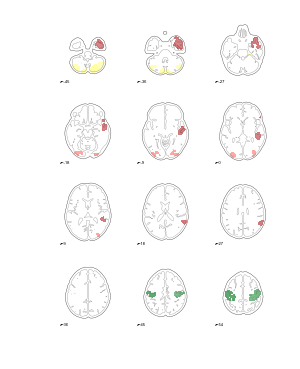

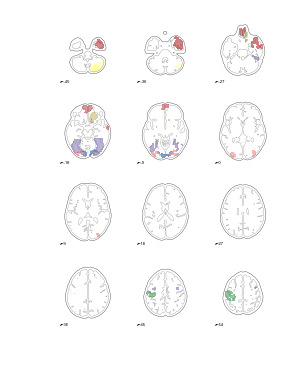

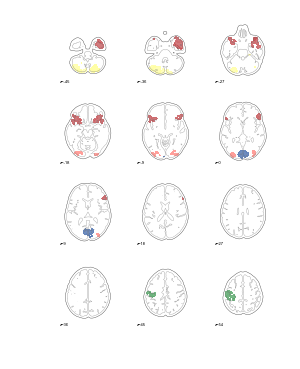

In [46]:
#figure 5
OrderRestRev = numpy.argsort(orderrest2)

for i in range(len(NeuroIMAGE)-1):
    brainval=np.mean(((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    brainval=brainval[OrderRestRev]
    plot3x4braincut(brainval,cut_coords='',title='slices_evol_'+NeuroIMAGE[i+1])
    plt.savefig('/'+fold+'/'+np.str(number)+'/slices_evol_SWall_5percentHighest_'+NeuroIMAGE[i+1]+'.pdf')
    plt.show()
    


In [47]:
# figure 5 (json file to build circles)
for i in range(3):
    brainval=np.mean(((np.abs((corSensageEdge[i][0]).T[1].T))+(np.abs((corSensageEdge[i][0]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    
    brainval2=((np.abs((corSensageEdge[i][0]).T[1].T))+(np.abs((corSensageEdge[i][0]).T[1].T)).T)
    brainshow=np.zeros((number,number))
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    brainshow=(brainshow.T)
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    
    
    ## make AGEmat.json
    colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.
    OrderRestRev = numpy.argsort(orderrest2)
    mat=[brainshow]
    if atlas=='ICPAtlas_v3_2':
        print 'to do'
    else:
        UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
        N=[20,11,22,22,18,8,18,13,7,17,23]
    pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
    pal2=np.concatenate([[pal[k] for j in range(N[k])] for k in range(number2)],axis=0)
    namearea=np.concatenate([['matAGE.'+net[k]+'.'+net[k]+'_'+np.str(j) for j in range(N[k])] for k in range(number2)],axis=0)
    
    netarea=np.concatenate([[net[k] for j in range(N[k])] for k in range(number2)],axis=0)
    print len(namearea)
    prov=copy.deepcopy(brainshow)
    
    prov[np.where(np.isnan(prov))]=0
    with open('/'+fold+'/'+np.str(number)+'/slices_evol_SWR_5percentHighest_CONNECTOME_'+NeuroIMAGE[i+1]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+NeuroIMAGE[i+1]+'","imports":[')
            keep=[]
            
            for j in range(number):
                if prov[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            if brainval[o]!=0.0:
                f.write('],"significant":'+np.str(np.sum(prov,0)[o]/3.)+'}')
            else:
                f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')

179
179
179


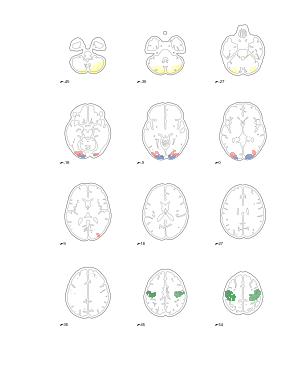

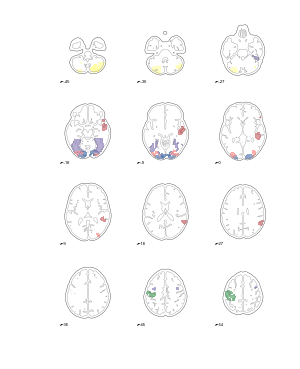

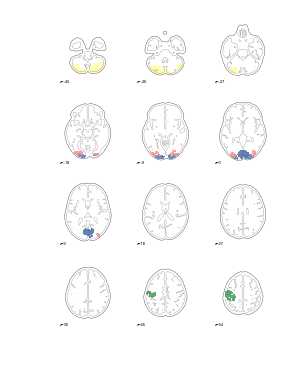

In [48]:
#supplementary material figure 5b
for i in range(len(NeuroIMAGE)-1):
    brainval=np.mean(((np.abs((corSensageEdge[i][0]).T[1].T))+(np.abs((corSensageEdge[i][0]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    brainval=brainval[OrderRestRev]
    plot3x4braincut(brainval,cut_coords='',title='slices_evol_'+NeuroIMAGE[i+1])
    plt.savefig('/'+fold+'/'+np.str(number)+'/slices_evol_SWR_5percentHighest_'+NeuroIMAGE[i+1]+'.pdf')
    plt.show() 

In [49]:
#supplementary material figure 5b (json file to build circles)
for i in range(3):
    brainval=np.mean(((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    
    
    brainval2=((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T)
    brainshow=np.zeros((number,number))
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    brainshow=(brainshow.T)
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    
    
    ## make AGEmat.json
    colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.
    OrderRestRev = numpy.argsort(orderrest2)
    mat=[brainshow]
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
    pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
    pal2=np.concatenate([[pal[k] for j in range(N[k])] for k in range(number2)],axis=0)
    namearea=np.concatenate([['matAGE.'+net[k]+'.'+net[k]+'_'+np.str(j) for j in range(N[k])] for k in range(number2)],axis=0)
    
    netarea=np.concatenate([[net[k] for j in range(N[k])] for k in range(number2)],axis=0)
    print len(namearea)
    prov=copy.deepcopy(brainshow)
    
    
    prov[np.where(np.isnan(prov))]=0
    with open('/'+fold+'/'+np.str(number)+'/slices_evol_SW_5percentHighest_CONNECTOME_'+NeuroIMAGE[i+1]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+NeuroIMAGE[i+1]+'","imports":[')
            keep=[]
            
            for j in range(number):
                if prov[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            if brainval[o]!=0.0:
                f.write('],"significant":'+np.str(np.sum(prov,0)[o]/3.)+'}')
            else:
                f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    
  
    
    

179
179
179


In [50]:
## for each of the subgroup only
import copy
tri=np.zeros((number,number))
tri[np.triu_indices(number,1)]=1
import statsmodels.api as sm
corSensageEdge=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
corSensageEdgeZ=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
corSensageEdgeZZ=np.array([np.zeros((4,number,number,2)) for t in range(1,4)])
pval=np.array([np.ones((4,number,number)) for t in range(1,4)])
locALL=[common,np.where((np.sign(np.abs(1-med2[1]))+np.sign(np.abs(1-med2[2]))-common)*tri==2),np.where((np.sign(np.abs(1-med2[1]))+np.sign(np.abs(1-med2[3]))-common)*tri==2),np.where((np.sign(np.abs(1-med2[2]))+np.sign(np.abs(1-med2[3]))-common)*tri==2)]
locALL_name=['modulated by all tasks','modulated by STOP and REWARD only','modulated by STOP and WM only','modulated by WM and REWARD only']
for t in range(1,4):
    behav=age[t]
    bmat=[]
    s0=[]
    
    for l,loc in enumerate(locALL):

        for j in range(len(loc[0])):
            p=[loc[0][j],loc[1][j]]
        

            results=sm.OLS(np.array(Upmatrices[t]).T[p[1]][p[0]],sm.add_constant(np.array([np.array(age[t])]).T,prepend=False)).fit()
            pval[t-1][l][p[0]][p[1]]=results.t_test(np.identity(2)).pvalue[1]
            corSensageEdge[t-1][l][p[0]][p[1]]=results.params*np.sign(np.mean(np.array(Upmatrices[t]).T[p[1]][p[0]]))
            if results.t_test(np.identity(2)).pvalue[1]<=0.05:
            #print p
                corSensageEdgeZ[t-1][l][p[0]][p[1]]=results.params*np.sign(np.mean(np.array(Upmatrices[t]).T[p[1]][p[0]]))


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


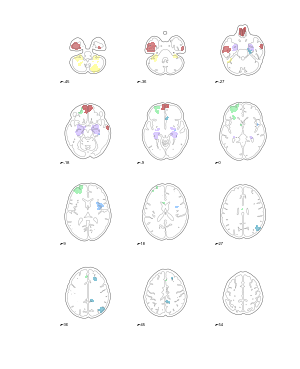

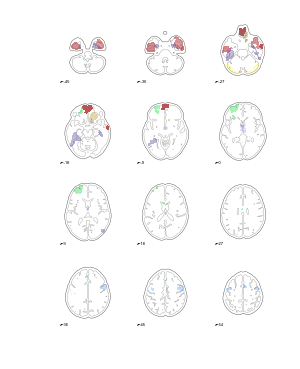

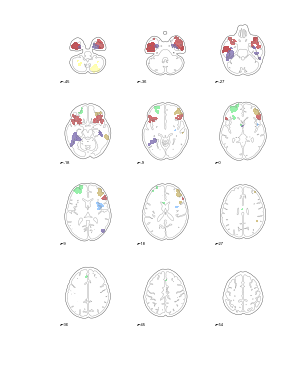

In [51]:
#supplementary material figure 5a
OrderRestRev = numpy.argsort(orderrest2)

for i in range(len(NeuroIMAGE)-1):
    brainval=np.mean(((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    brainval=brainval[OrderRestRev]
    plot3x4braincut(brainval,cut_coords='',title='slices_evol_'+NeuroIMAGE[i+1])
    plt.savefig('/'+fold+'/'+np.str(number)+'/slices_evol_SWonly_5percentHighest_'+NeuroIMAGE[i+1]+'.pdf')
    plt.show()
    


In [52]:
#supplementary material figure 5a (json file to build circles)
for i in range(3):
    brainval=np.mean(((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T),0)
    brainval[np.argsort(brainval)[:len(brainval)-9]]=0
    
    
    brainval2=((np.abs((corSensageEdge[i][2]).T[1].T))+(np.abs((corSensageEdge[i][2]).T[1].T)).T)
    brainshow=np.zeros((number,number))
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    brainshow=(brainshow.T)
    brainshow[np.where(brainval!=0)]=brainval2[np.where(brainval!=0)]
    
    
    ## make AGEmat.json
    colorgroup=np.array([(0,204,0),(0,204,204),(255,0,0),(255,102,178),(204,0,204),(178,102,255),(0,0,255)])/255.
    OrderRestRev = numpy.argsort(orderrest2)
    mat=[brainshow]
    UpArea=[0,20,31,53,75,93,101,119,132,139,156,179]
    N=[20,11,22,22,18,8,18,13,7,17,23]
    pal=np.concatenate([sns.color_palette("deep",6),sns.color_palette("pastel",6)],axis=0)
    pal2=np.concatenate([[pal[k] for j in range(N[k])] for k in range(number2)],axis=0)
    namearea=np.concatenate([['matAGE.'+net[k]+'.'+net[k]+'_'+np.str(j) for j in range(N[k])] for k in range(number2)],axis=0)
    
    netarea=np.concatenate([[net[k] for j in range(N[k])] for k in range(number2)],axis=0)
    print len(namearea)
    prov=copy.deepcopy(brainshow)
    
    
    prov[np.where(np.isnan(prov))]=0
    with open('/'+fold+'/'+np.str(number)+'/slices_evol_SWonly_5percentHighest_CONNECTOME_'+NeuroIMAGE[i+1]+'.json','w') as f:
        f.write('[\n')
        for o in range(number):
            f.write('{"name":"'+namearea[o]+'","size":6000,"net":"'+netarea[o]+'","type":"'+NeuroIMAGE[i+1]+'","imports":[')
            keep=[]
            
            for j in range(number):
                if prov[o][j]!=0:
                
                    keep+='"'+namearea[j]+'",'
            if keep!=[]:
            
                f.write(''.join(keep[:len(keep)-1]))
            if brainval[o]!=0.0:
                f.write('],"significant":'+np.str(np.sum(prov,0)[o]/3.)+'}')
            else:
                f.write(']}')
            
            if o==number-1:
                f.write('\n]')
            else:
                f.write(',\n')
    
    
  
    
    

179
179
179


# edge level - ellipsoid

In [53]:
#http://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos,nstd=2, ax=None, cross=1, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
    theta=(theta)*np.pi/180.
    width=width/2.
    height=height/2.
    ax.add_artist(ellip)
    
    
    if cross==1:
        ax.plot([pos[0]+height*np.sin(theta),pos[0]-height*np.sin(theta)],[pos[1]-np.cos(theta)*height,pos[1]+np.cos(theta)*height],'b')
    
        ax.plot([pos[0]-np.cos(theta)*width,pos[0]+np.cos(theta)*width],[pos[1]-np.sin(theta)*width,pos[1]+np.sin(theta)*width],'b')
    
    return ellip

In [54]:
#http://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def param_ell(points, nstd=2):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        
    Returns
    -------
        width, height, theta, height/width
    """
    
    cov = np.cov(points, rowvar=False)
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    if theta>0:
        keep=[width, height, theta, height/width]
    else:
        keep=[width, height, 180+theta, height/width]
    
    return keep

In [55]:

import statsmodels.api as sm
slopealledge=np.zeros((4,number,number))
slopealledgepval=np.zeros((4,number,number))
slopealledgeini=np.zeros((4,number,number))

for t3 in range(4):
    p=np.triu_indices(number,1)
    for i in range(len(p[0])):
        test=np.zeros(300)
        if t3==0:
            test[range(len(Upmatrices[t3]))]=np.array([(np.abs(Upmatrices[t3][s][p[0][i]][p[1][i]])) for s in range(len(Upmatrices[t3]))])
        else:
            test[indexPopTpair[t3-1][0]]=np.array([(np.abs(Upmatrices[t3][s][p[0][i]][p[1][i]])) for s in range(len(Upmatrices[t3]))])
    
        notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
        results=sm.OLS(((test[notnan])),sm.add_constant(age[0])[notnan],prepend=False).fit()
        slopealledge[t3][p[0][i]][p[1][i]]=results.params[1]
        slopealledgeini[t3][p[0][i]][p[1][i]]=results.params[0]
        slopealledgepval[t3][p[0][i]][p[1][i]]=results.t_test(np.identity(2)).pvalue[1]
np.save('/'+fold+'/'+np.str(number)+'/slopealledge',slopealledge)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgepval',slopealledgepval)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgeini',slopealledgeini)
    

In [56]:
slopealledge=np.load('/'+fold+'/'+np.str(number)+'/slopealledge.npy')
slopealledgepval=np.load('/'+fold+'/'+np.str(number)+'/slopealledgepval.npy')
slopealledgeini=np.load('/'+fold+'/'+np.str(number)+'/slopealledgeini.npy')

In [57]:
# integrating movement
import statsmodels.formula.api as sm
slopealledgeA=np.zeros((4,number,number))
slopealledgeAxM=np.zeros((4,number,number))
slopealledgeM=np.zeros((4,number,number))
slopealledgepvalA=np.zeros((4,number,number))
slopealledgepvalM=np.zeros((4,number,number))
slopealledgepvalAxM=np.zeros((4,number,number))
slopealledgeiniAM=np.zeros((4,number,number))

for t3 in range(4):
    p=np.triu_indices(number,1)
    for i in range(len(p[0])):
        test=np.zeros(300)
        if t3==0:
            test[range(len(Upmatrices[t3]))]=np.array([(np.abs(Upmatrices[t3][s][p[0][i]][p[1][i]])) for s in range(len(Upmatrices[t3]))])
        else:
            test[indexPopTpair[t3-1][0]]=np.array([(np.abs(Upmatrices[t3][s][p[0][i]][p[1][i]])) for s in range(len(Upmatrices[t3]))])
    
        notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
        dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':test[notnan]})
        results=sm.ols(formula='pot ~ mvt + age+ mvt*age',data=dataframe).fit()        
        
        slopealledgeA[t3][p[0][i]][p[1][i]]=results.params[2]
        slopealledgeAxM[t3][p[0][i]][p[1][i]]=results.params[3]
        slopealledgeM[t3][p[0][i]][p[1][i]]=results.params[1]
        slopealledgeiniAM[t3][p[0][i]][p[1][i]]=results.params[0]
        slopealledgepvalA[t3][p[0][i]][p[1][i]]=results.t_test(np.identity(4)).pvalue[2]
        slopealledgepvalM[t3][p[0][i]][p[1][i]]=results.t_test(np.identity(4)).pvalue[1]
        slopealledgepvalAxM[t3][p[0][i]][p[1][i]]=results.t_test(np.identity(4)).pvalue[3]
np.save('/'+fold+'/'+np.str(number)+'/slopealledgeA',slopealledgeA)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgeM',slopealledgeM)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgeAxM',slopealledgeAxM)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgepvalA',slopealledgepvalA)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgepvalM',slopealledgepvalM)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgepvalAxM',slopealledgepvalAxM)
np.save('/'+fold+'/'+np.str(number)+'/slopealledgeiniAM',slopealledgeiniAM)
    

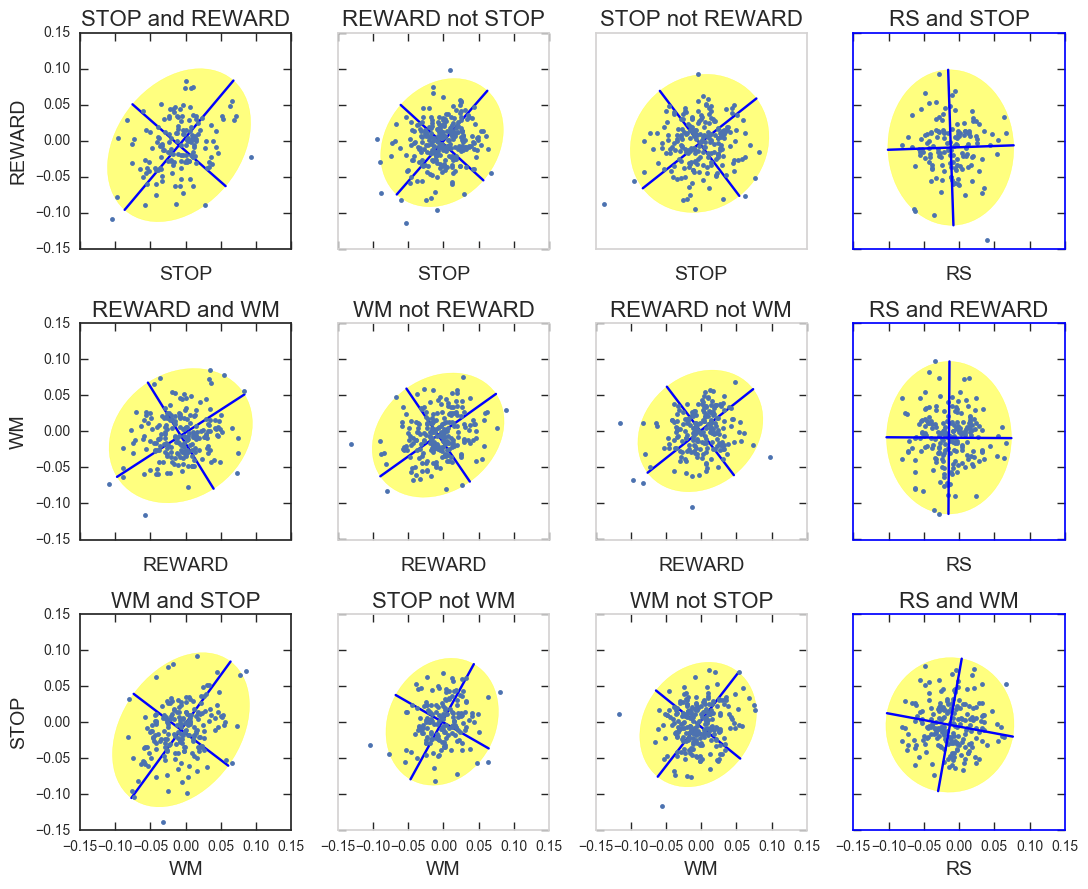

In [58]:
#figure 6
sns.set_style('white')
sns.despine()
plt.figure(figsize=(11,9))


for e,t in enumerate([[1,2],[2,3],[3,1]]):
    
    
    ax = plt.subplot(3,4,3+e*4)
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.title(NeuroIMAGE[t[0]]+' not '+NeuroIMAGE[t[1]], fontsize=16)
    selection1=np.sign(np.abs(1-med2))[t[0]]-np.sign(np.abs(1-med2))[t[1]]
    selection1[np.where(selection1<0)]=0
    selection2=np.sign(np.abs(1-med2))[t[1]]-np.sign(np.abs(1-med2))[t[0]]
    selection2[np.where(selection2<0)]=0
    selection0=selection1+selection2
    
    points=np.array([slopealledge[t[0]][np.triu_indices(number,1)][np.where(selection1[np.triu_indices(number,1)]!=0)],slopealledge[t[1]][np.triu_indices(number,1)][np.where(selection1[np.triu_indices(number,1)]!=0)]]).T
    
    
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    x,y=points.T
    plt.plot(x,y,'.')
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.subplot(3,4,1+e*4)
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.ylabel(NeuroIMAGE[t[1]], fontsize=14)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.title(NeuroIMAGE[t[0]]+' and '+NeuroIMAGE[t[1]], fontsize=16)
    points=np.array([slopealledge[t[0]][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[t[0]]+np.sign(np.abs(1-med2))[t[1]])[np.triu_indices(number,1)]==2)],slopealledge[t[1]][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[t[0]]+np.sign(np.abs(1-med2))[t[1]])[np.triu_indices(number,1)]==2)]]).T
    x,y=points.T
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    plt.plot(x,y,'.')
    
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    ax = plt.subplot(3,4,2+e*4)
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    
    plt.title(NeuroIMAGE[t[1]]+' not '+NeuroIMAGE[t[0]], fontsize=16)
    
    points=np.array([slopealledge[t[0]][np.triu_indices(number,1)][np.where(selection2[np.triu_indices(number,1)]!=0)],slopealledge[t[1]][np.triu_indices(number,1)][np.where(selection2[np.triu_indices(number,1)]!=0)]]).T
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    x,y=points.T
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    plt.plot(x,y,'.')
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    

for t in range(1,4):
    ax = plt.subplot(3,4,4*t)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.title(NeuroIMAGE[0]+' and '+NeuroIMAGE[t], fontsize=16)
    points=np.array([slopealledge[0][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)],slopealledge[t][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)]]).T
    x,y=points.T
    
    plt.plot(x,y,'.')
    pvalkeep=np.min(np.array([slopealledgepval[0][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)],slopealledgepval[t][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)]]).T,1)
    plot_point_cov(np.array(points), nstd=3, alpha=0.5, color='yellow')
    plt.xlabel(NeuroIMAGE[0], fontsize=14)
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    ax.spines['bottom'].set_color('b')
    ax.spines['top'].set_color('b')
    ax.spines['right'].set_color('b')
    ax.spines['left'].set_color('b')
    if t!=3:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/ellisoid_all_EVOL.pdf')
plt.show()

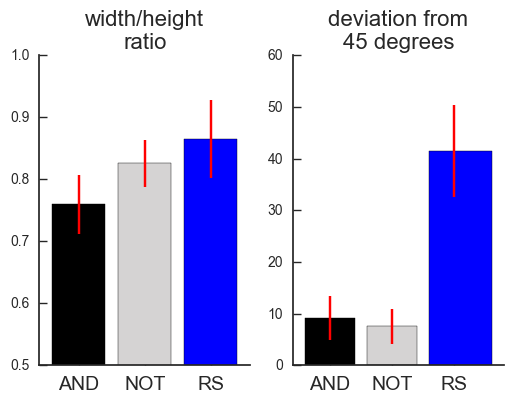

In [59]:
#figure 6 bottom
thetaNOTANDtask=[np.abs(45-i) for i in [30.6138779605,40.9164723132,37.0395285025,39.6361699608,36.676809779,50.1011346087]]
ratioNOTANDtask=[0.821096230215,0.83882311749,0.769888326547,0.817750994454,0.810785733281,0.895878378468]
thetaANDtask=[np.abs(45-i) for i in [35.9270531751,30.4801654189,48.9344612357]]
ratioANDtask=[0.708676593106,0.823717971738,0.745923361842]

restratio=[0.953305964389,0.814094038363,0.82566558079]
resttheta=[np.abs(45-i) for i in [94.1248940906,91.2625481159,74.0286589116]]

plt.subplot(1,2,1)
sns.set_style('ticks')
plt.tick_params(direction='in')
plt.bar([0],[np.mean(ratioANDtask)],0.8,color='k')
plt.errorbar([0.4],[np.mean(ratioANDtask)],[np.std(ratioANDtask)],color='r')
plt.bar([1],[np.mean(ratioNOTANDtask)],0.8,color='#d5d3d3')
plt.errorbar([1.4],[np.mean(ratioNOTANDtask)],[np.std(ratioNOTANDtask)],color='r')
plt.bar([2],[np.mean(restratio)],0.8,color='b')
plt.errorbar([2.4],[np.mean(restratio)],[np.std(restratio)],color='r')
plt.ylim([.5,1])
plt.xlim([-0.2,3])
plt.title('width/height\nratio', fontsize=16)
plt.xticks([.4,1.4,2.4],['AND','NOT','RS'], fontsize=14)
sns.despine()
plt.subplot(1,2,2)
plt.xlim([-0.2,3.2])
sns.despine()
plt.tick_params(direction='in')
plt.bar([0],[np.mean(thetaANDtask)],0.8,color='k')
plt.errorbar([0.4],[np.mean(thetaANDtask)],[np.std(thetaANDtask)],color='r')
plt.bar([1],[np.mean(thetaNOTANDtask)],0.8,color='#d5d3d3')
plt.errorbar([1.4],[np.mean(thetaNOTANDtask)],[np.std(thetaNOTANDtask)],color='r')
plt.bar([2],[np.mean(resttheta)],1,color='b')
plt.errorbar([2.4],[np.mean(resttheta)],[np.std(resttheta)],color='r')
plt.xticks([.4,1.4,2.4],['AND','NOT','RS'], fontsize=14)
plt.title('deviation from\n45 degrees', fontsize=16)
plt.savefig('/'+fold+'/'+np.str(number)+'/ellisoid_all_EVOL_bar.pdf')
plt.show()

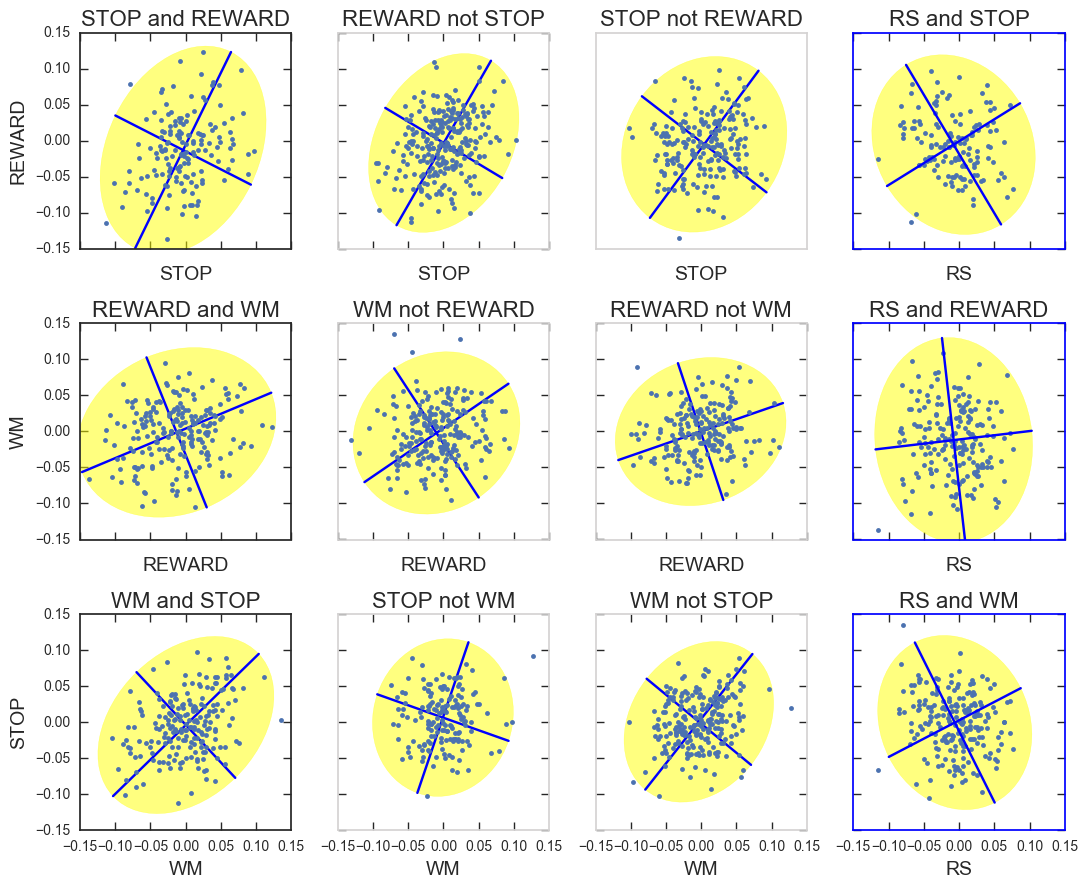

In [60]:
## integrating movement
#supplementary material figure 6
import copy


sns.set_style('white')
sns.despine()
plt.figure(figsize=(11,9))


for e,t in enumerate([[1,2],[2,3],[3,1]]):
    
    
    ax = plt.subplot(3,4,3+e*4)
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.title(NeuroIMAGE[t[0]]+' not '+NeuroIMAGE[t[1]], fontsize=16)
    selection1=np.sign(np.abs(1-med2))[t[0]]-np.sign(np.abs(1-med2))[t[1]]
    selection1[np.where(selection1<0)]=0
    selection2=np.sign(np.abs(1-med2))[t[1]]-np.sign(np.abs(1-med2))[t[0]]
    selection2[np.where(selection2<0)]=0
    selection0=selection1+selection2
    points=np.array([slopealledgeA[t[0]][np.triu_indices(number,1)][np.where(selection1[np.triu_indices(number,1)]!=0)],slopealledgeA[t[1]][np.triu_indices(number,1)][np.where(selection1[np.triu_indices(number,1)]!=0)]]).T
    
    
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    x,y=points.T
    plt.plot(x,y,'.')
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    plt.subplot(3,4,1+e*4)
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.ylabel(NeuroIMAGE[t[1]], fontsize=14)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.title(NeuroIMAGE[t[0]]+' and '+NeuroIMAGE[t[1]], fontsize=16)
    points=np.array([slopealledgeA[t[0]][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[t[0]]+np.sign(np.abs(1-med2))[t[1]])[np.triu_indices(number,1)]==2)],slopealledgeA[t[1]][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[t[0]]+np.sign(np.abs(1-med2))[t[1]])[np.triu_indices(number,1)]==2)]]).T
    x,y=points.T
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    plt.plot(x,y,'.')
    
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    ax = plt.subplot(3,4,2+e*4)
    plt.xlabel(NeuroIMAGE[t[0]], fontsize=14)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    if e!=2:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    
    plt.title(NeuroIMAGE[t[1]]+' not '+NeuroIMAGE[t[0]], fontsize=16)
    
    points=np.array([slopealledgeA[t[0]][np.triu_indices(number,1)][np.where(selection2[np.triu_indices(number,1)]!=0)],slopealledgeA[t[1]][np.triu_indices(number,1)][np.where(selection2[np.triu_indices(number,1)]!=0)]]).T
    ax.spines['bottom'].set_color('#d5d3d3')
    ax.spines['top'].set_color('#d5d3d3')
    ax.spines['right'].set_color('#d5d3d3')
    ax.spines['left'].set_color('#d5d3d3')
    x,y=points.T
    plot_point_cov(points, nstd=3, alpha=0.5, color='yellow')
    plt.plot(x,y,'.')
    sns.set_style('ticks')
    plt.tick_params(direction='in')
    

for t in range(1,4):
    ax = plt.subplot(3,4,4*t)
    plt.xlim([-0.15,0.15])
    plt.ylim([-0.15,0.15])
    plt.title(NeuroIMAGE[0]+' and '+NeuroIMAGE[t], fontsize=16)
    points=np.array([slopealledgeA[0][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)],slopealledgeA[t][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)]]).T
    x,y=points.T
    
    plt.plot(x,y,'.')
    pvalkeep=np.min(np.array([slopealledgepvalA[0][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)],slopealledgepvalA[t][np.triu_indices(number,1)][np.where((np.sign(np.abs(1-med2))[0]+np.sign(np.abs(1-med2))[t])[np.triu_indices(number,1)]==2)]]).T,1)
    
    plot_point_cov(np.array(points), nstd=3, alpha=0.5, color='yellow')
    plt.xlabel(NeuroIMAGE[0], fontsize=14)
    
    plt.yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    ax.spines['bottom'].set_color('b')
    ax.spines['top'].set_color('b')
    ax.spines['right'].set_color('b')
    ax.spines['left'].set_color('b')
    if t!=3:
        plt.xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15],['','','','','','',''])
    sns.set_style('ticks')
    plt.tick_params(direction='in')
plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/ellisoid_all_EVOL_agealone.pdf')
plt.show()

In [61]:
import statsmodels.api as sm
windowsize=1.
Nwindow=7
slideslopealledge=[np.zeros((len(Upmatrices[t])-(Nwindow-1),number,number)) for t in range(len(NeuroIMAGE))]
slideslopealledgeage=[np.zeros(len(Upmatrices[t])-(Nwindow-1)) for t in range(len(NeuroIMAGE))]
p=np.triu_indices(number,1)

for t3 in range(4):
    if t3==0:
        orderage=np.argsort(age[0])
    else:
        orderage=np.argsort(np.array(age[0])[indexPopTpair[t3-1][0]])
    j2=-1
    for j in range(len((np.where(np.array(age[0])[orderage]<=np.max(np.array(age[0])[orderage])-(windowsize))[0]))):
        if t3==0:
            selectage=orderage[j:1+np.max(np.where(np.array(age[0])[orderage]<=np.array(age[0])[orderage][j]+(windowsize))[0])]
            
        else:
            selectage=orderage[j:1+np.max(np.where(np.array(age[0])[indexPopTpair[t3-1][0]][orderage]<=np.array(age[0])[indexPopTpair[t3-1][0]][orderage][j]+(windowsize))[0])]
            
        if len(selectage)>=Nwindow:
            if len(selectage)>Nwindow:
                selectage2=selectage[1:len(selectage)-1]
                random.shuffle(selectage2)
                selectage=np.concatenate([[selectage[0],selectage[len(selectage)-1]],selectage2[:5]],axis=0)
            
            j2+=1
            test=np.zeros((300,len(np.triu_indices(number,1)[0])))
            if t3==0:
                test[selectage]=np.array([(np.abs(np.array(Upmatrices[t3][s])[np.triu_indices(number,1)])) for s in selectage])              
            else:
                test[np.array(indexPopTpair[t3-1][0])[selectage]]=np.array([(np.abs(np.array(Upmatrices[t3][s])[np.triu_indices(number,1)])) for s in selectage])
    
            notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
            prov=np.zeros((number,number))
            prov[np.triu_indices(number,1)]=(np.linalg.inv(sm.add_constant(age[0])[notnan].T.dot(sm.add_constant(age[0])[notnan])).dot(sm.add_constant(age[0])[notnan].T).dot(test[notnan]))[1]
            slideslopealledge[t3][j2]=prov+prov.T
            slideslopealledgeage[t3][j2]=np.mean(np.array(age[0])[notnan])
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledge16aug',slideslopealledge)
    
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledgeage16aug',slideslopealledgeage)
    

    print t3
    
                

0
1
2
3


/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


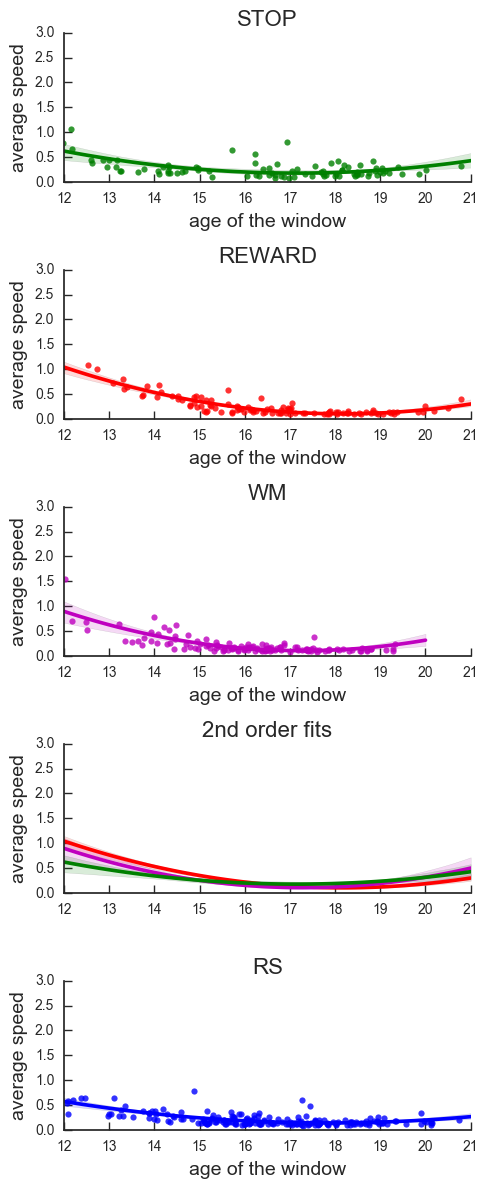

In [62]:
### figure 7 by1year and 7sub
c=['b','g','r','m']
sns.set_style('white')
sns.despine()
max2=[0,50,80,0.1]
plt.figure(figsize=(5,12))
for t3 in range(len(NeuroIMAGE)): 

    sns.set_style('ticks')
    if t3==0:
        plt.subplot(5,1,5)
    else:
        plt.subplot(5,1,t3)
    keeploc=np.where(np.abs(1-med2[t3])[np.triu_indices(number,1)]!=0)
    su=np.where(slideslopealledgeage[t3]!=0.)[0]
    
    sns.regplot(np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),order=2,color=c[t3])
    
    plt.ylim([0,1.2])#3
    plt.xlim([12,21])
    plt.xlabel('age of the window',fontsize=14)
    
    plt.ylabel('average speed',fontsize=14)
    plt.title(NeuroIMAGE[t3],fontsize=16)
    if t3!=0:
        plt.subplot(5,1,4)
        sx=np.poly1d(np.polyfit([np.array(slideslopealledgeage[t3][s]) for s in su],np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),2))
        orderage=np.argsort([np.array(slideslopealledgeage[t3][s]) for s in su])
        sns.regplot(np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),order=2,color=c[t3],marker='')
        plt.title('2nd order fits',fontsize=16)
        plt.ylabel('average speed',fontsize=14)
        plt.ylim([0,1.2])#3
        plt.xlim([12,21])
        plt.legend()
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        if t3==1:
            keep=[np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1)]
    if t3==0:
        plt.subplot(5,1,5)
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    else:
        plt.subplot(5,1,t3)
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    sns.despine()
    sns.set_style('ticks')
    
    
    plt.tick_params(direction='in')
plt.subplot(5,1,4)
sns.regplot(keep[0],keep[1],order=2,color=c[1],marker='')
plt.tight_layout()

plt.savefig('/'+fold+'/'+np.str(number)+'/carnelsecondorderWindow1year7sub.pdf')

plt.show()


In [63]:
#integrating movement
#supplementary material figure 7
import statsmodels.formula.api as sm

import pandas
import patsy
windowsize=1.
Nwindow=7
slideslopealledge=[np.zeros((len(Upmatrices[t])-(Nwindow-1),number,number)) for t in range(len(NeuroIMAGE))]
slideslopealledgeM=[np.zeros((len(Upmatrices[t])-(Nwindow-1),number,number)) for t in range(len(NeuroIMAGE))]
slideslopealledgeAxM=[np.zeros((len(Upmatrices[t])-(Nwindow-1),number,number)) for t in range(len(NeuroIMAGE))]
slideslopealledgeini=[np.zeros((len(Upmatrices[t])-(Nwindow-1),number,number)) for t in range(len(NeuroIMAGE))]
slideslopealledgeage=[np.zeros(len(Upmatrices[t])-(Nwindow-1)) for t in range(len(NeuroIMAGE))]
p=np.triu_indices(number,1)

for t3 in range(4):
    if t3==0:
        orderage=np.argsort(age[0])
    else:
        orderage=np.argsort(np.array(age[0])[indexPopTpair[t3-1][0]])
    j2=-1
    for j in range(len((np.where(np.array(age[0])[orderage]<=np.max(np.array(age[0])[orderage])-(windowsize))[0]))):
        if t3==0:
            selectage=orderage[j:1+np.max(np.where(np.array(age[0])[orderage]<=np.array(age[0])[orderage][j]+(windowsize))[0])]
            
        else:
            selectage=orderage[j:1+np.max(np.where(np.array(age[0])[indexPopTpair[t3-1][0]][orderage]<=np.array(age[0])[indexPopTpair[t3-1][0]][orderage][j]+(windowsize))[0])]
            
        if len(selectage)>=Nwindow:
            if len(selectage)>Nwindow:
                selectage2=selectage[1:len(selectage)-1]
                random.shuffle(selectage2)
                selectage=np.concatenate([[selectage[0],selectage[len(selectage)-1]],selectage2[:5]],axis=0)
                

            j2+=1
            test=np.zeros((300,len(np.triu_indices(number,1)[0])))
            if t3==0:
                test[selectage]=np.array([(np.abs(np.array(Upmatrices[t3][s])[np.triu_indices(number,1)])) for s in selectage])              
                notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
                dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array(rms[0])[notnan],'pot':np.ones(len(age[0]))[notnan]})
            else:
                test[np.array(indexPopTpair[t3-1][0])[selectage]]=np.array([(np.abs(np.array(Upmatrices[t3][s])[np.triu_indices(number,1)])) for s in selectage])
    
                notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
                dataframe=pandas.DataFrame({'age':np.array(age[0])[notnan],'mvt':np.array([(np.abs(np.array(rms[t3][s]))) for s in selectage]),'pot':np.ones(len(age[0]))[notnan]})
            
            
            
            f='pot ~ mvt + age +age*mvt'
            y,X=patsy.dmatrices(f,dataframe,return_type='dataframe')
            
            
            prov2=(np.linalg.inv(np.array([X['Intercept'],X['age'],X['age:mvt'],X['mvt']]).dot(np.array([X['Intercept'],X['age'],X['age:mvt'],X['mvt']]).T)).dot(np.array([X['Intercept'],X['age'],X['age:mvt'],X['mvt']])).dot(test[notnan]))
            prov=np.zeros((number,number))
            prov[np.triu_indices(number,1)]=prov2[1]
            slideslopealledge[t3][j2]=prov+prov.T
            prov[np.triu_indices(number,1)]=prov2[0]
            slideslopealledgeini[t3][j2]=prov+prov.T
            prov[np.triu_indices(number,1)]=prov2[2]
            slideslopealledgeAxM[t3][j2]=prov+prov.T
            prov[np.triu_indices(number,1)]=prov2[3]
            slideslopealledgeM[t3][j2]=prov+prov.T
            slideslopealledgeage[t3][j2]=np.mean(np.array(age[0])[notnan])
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledge16augAxM_A',slideslopealledge)
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledge16augAxM_AxM',slideslopealledgeAxM)
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledge16augAxM_M',slideslopealledgeM)
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledge16augAxM_ini',slideslopealledgeini)
    
    np.save('/'+fold+'/'+np.str(number)+'/slideslopealledgeage16augAxM',slideslopealledgeage)
    

    print t3
    
                

0
1
2
3


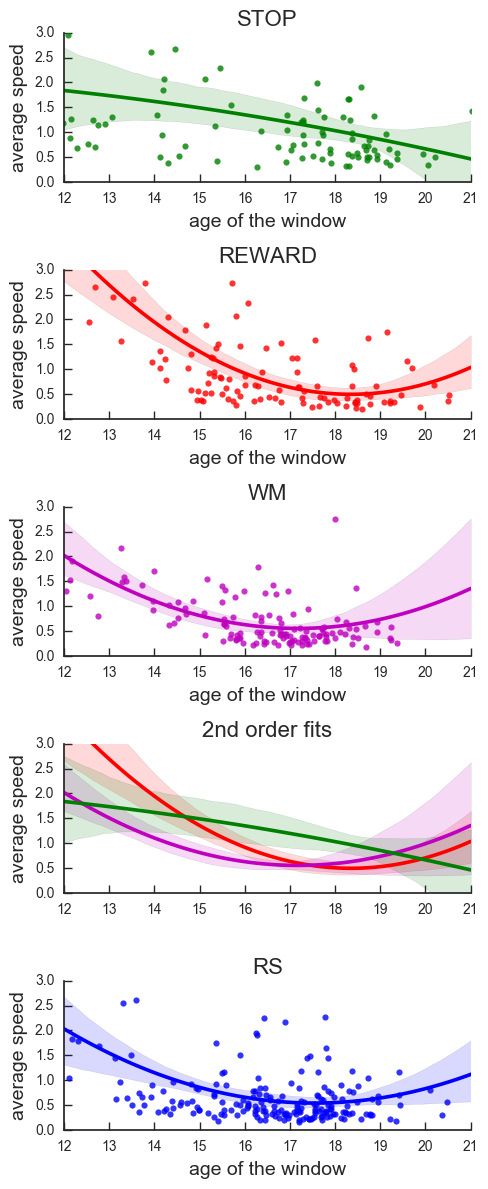

In [64]:
### not in the paper / supplementary material figure 7 for Age and movement interaction terme / by1year and 7sub
c=['b','g','r','m']
sns.set_style('white')
sns.despine()
max2=[0,50,80,0.1]
plt.figure(figsize=(5,12))
for t3 in range(len(NeuroIMAGE)): 

    sns.set_style('ticks')
    if t3==0:
        plt.subplot(5,1,5)
    else:
        plt.subplot(5,1,t3)
    keeploc=np.where(np.abs(1-med2[t3])[np.triu_indices(number,1)]!=0)
    su=np.where(slideslopealledgeage[t3]!=0.)[0]
    
    sns.regplot(np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),order=2,color=c[t3])
    plt.ylim([0,3])
    plt.xlim([12,21])
    plt.xlabel('age of the window',fontsize=14)
    
    plt.ylabel('average speed',fontsize=14)
    plt.title(NeuroIMAGE[t3],fontsize=16)
    if t3!=0:
        plt.subplot(5,1,4)
        sx=np.poly1d(np.polyfit([np.array(slideslopealledgeage[t3][s]) for s in su],np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),2))
        orderage=np.argsort([np.array(slideslopealledgeage[t3][s]) for s in su])
        sns.regplot(np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1),order=2,color=c[t3],marker='')
        
        plt.title('2nd order fits',fontsize=16)
        plt.ylabel('average speed',fontsize=14)
        plt.ylim([0,3])
        plt.xlim([12,21])
        plt.legend()
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        if t3==1:
            keep=[np.array([slideslopealledgeage[t3][s] for s in su]),np.mean(np.abs([np.array(slideslopealledge[t3][s])[np.triu_indices(number,1)][keeploc] for s in su]),1)]
    if t3==0:
        plt.subplot(5,1,5)
        
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    else:
        plt.subplot(5,1,t3)
        
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    sns.despine()
    sns.set_style('ticks')
    
    
    plt.tick_params(direction='in')
plt.subplot(5,1,4)
sns.regplot(keep[0],keep[1],order=2,color=c[1],marker='')
plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/carnelsecondorderWindow1year7subAge_AxM.pdf')
plt.show()


In [65]:
#stop signal reaction time and reaction time variability
myquery2= """SELECT Daan_Data.Subjects,  Daan_Data.RTV, Daan_Data.SSRT
    FROM
    Daan_Data"""


allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['subject','RTV','SSRT'],"image_private")#, 'RT'
for s in allinfo_behav.keys():
    if allinfo_behav[s]['RTV']==None:
        del allinfo_behav[s]

stopIndex=[[] for t in range(len(data))]
stopRTV=[[] for t in range(len(data))]
stopSSRT=[[] for t in range(len(data))]
for t in range(len(suj)):
    for i in range(len(suj[t])):
        if suj[t][i] in allinfo_behav.keys():
            stopIndex[t].append(i)
            stopRTV[t].append(allinfo_behav[suj[t][i]]['RTV'])
            stopSSRT[t].append(allinfo_behav[suj[t][i]]['SSRT'])
np.save('/stopIndex',stopIndex)#file available
np.save('/stopRTV',stopRTV)#file available
np.save('/stopSSRT',stopSSRT)#file available

####################
####################
#REWARD reaction time difference
myquery2= """SELECT NPO_Reward.Subject,  NPO_Reward.DiffRT
    FROM
    NPO_Reward"""



allinfo_behav = rc_GetInfoFromDb.get_query(myquery2,['subject','RTdiff'],"danvrhe")
for s in allinfo_behav.keys():
    if allinfo_behav[s]['RTdiff']==None:
        del allinfo_behav[s]

rewardIndex=[[] for t in range(len(data))]
rewardRTdiff=[[] for t in range(len(data))]
for t in range(len(suj)):
    for i in range(len(suj[t])):
        if suj[t][i] in allinfo_behav.keys():
            rewardIndex[t].append(i)
            rewardRTdiff[t].append(allinfo_behav[suj[t][i]]['RTdiff'])
np.save('/rewardIndex',rewardIndex)#file available
np.save('/rewardRTdiff',rewardRTdiff)#file available

####################
####################

wm=open('/WMperformance2.txt','r').read().split()
wm=np.reshape(wm,(len(wm)/2,2))


wmIndex=[[] for t in range(len(data))]
wmPerf=[[] for t in range(len(data))]
for t in range(len(suj)):
    for i in range(len(suj[t])):
        if suj[t][i] in wm.T[0]:
            wmIndex[t].append(i)
            wmPerf[t].append(np.float(wm[np.where(wm.T[0]==suj[t][i])][0][1]))
np.save('/wmIndex',wmIndex)#file available
np.save('/wmPerf',wmPerf)#file available



In [66]:
####with window 1 year and subject 7
import statsmodels.api as sm
windowsize=1.
Nwindow=7
slideslopebehav=[np.zeros((len(Upmatrices[t])-(windowsize-1))) for t in range(len(NeuroIMAGE))]
slideslopebehavage=[np.zeros(len(Upmatrices[t])-(windowsize-1)) for t in range(len(NeuroIMAGE))]

slideslopebehavini=[np.zeros((len(Upmatrices[t])-(windowsize-1))) for t in range(len(NeuroIMAGE))]
behavvalue=[[stopSSRT[1],'ssrt',stopIndex[1]],[rewardRTdiff[2],'RTdiff',rewardIndex[2]],[wmPerf[3],'perf',wmIndex[3]]]


for t3 in range(1,4):
    
    orderage=np.argsort(np.array(age[0])[indexPopTpair[t3-1][0]])
    j2=-1
    for j in range(len((np.where(np.array(age[0])[orderage]<=np.max(np.array(age[0])[orderage])-(windowsize))[0]))):
        
        selectage=orderage[j:1+np.max(np.where(np.array(age[0])[indexPopTpair[t3-1][0]][orderage]<=np.array(age[0])[indexPopTpair[t3-1][0]][orderage][j]+(windowsize))[0])]
        if len(selectage)>=Nwindow:
            if len(selectage)>Nwindow:
                selectage2=selectage[1:len(selectage)-1]
                random.shuffle(selectage2)
                selectage=np.concatenate([[selectage[0],selectage[len(selectage)-1]],selectage2[:5]],axis=0)
                
            behav=behavvalue[t3-1]
            bmat=[]
            s0=[]
            for s in selectage:
                if s in behav[2] :
                    
                    bmat+=[np.array(behav[0])[np.where(np.array(behav[2])==s)]]
                    s0+=[s]
            j2+=1
            test=np.zeros(300)
            test[np.array(indexPopTpair[t3-1][0])[selectage]]=[bmat[s][0] for s in range(len(bmat))]
            notnan=np.array([s for s in range(len(test)) if s in np.where((test)!=0)[0]])
            results=sm.OLS(test[notnan],sm.add_constant(age[0])[notnan],prepend=False).fit()
            slideslopebehav[t3][j]=results.params[1]
            slideslopebehavini[t3][j]=results.params[0]
            slideslopebehavage[t3][j]=np.mean(np.array(age[0])[notnan])
            

/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mrstats/maamen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


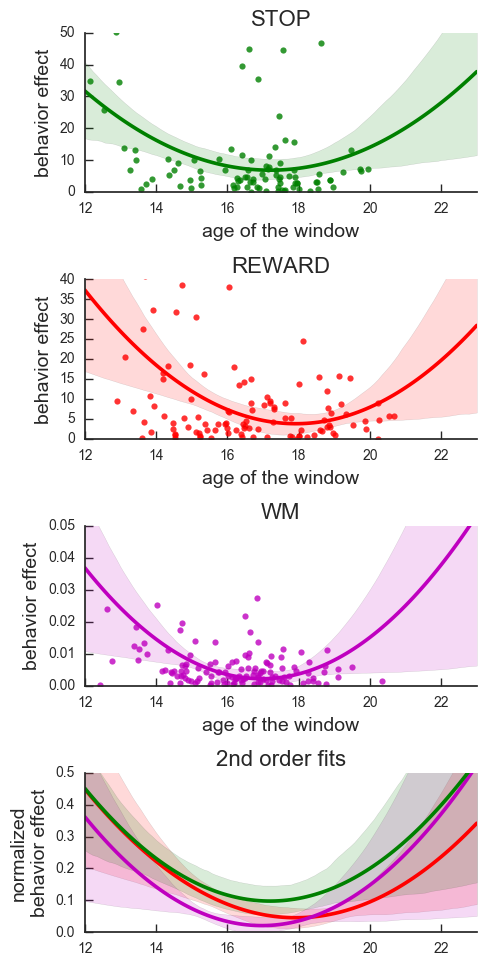

In [67]:
### supplementary material figure 8

c=['b','g','r','m']
sns.set_style('white')
sns.despine()
max2=[0,50,40,0.05]
plt.figure(figsize=(5,12))

for t3 in range(1,len(NeuroIMAGE)): 
    sns.set_style('ticks')
    if t3==0:
        plt.subplot(5,1,5)
    else:
        plt.subplot(5,1,t3)
    keeploc=np.where(np.abs(1-med2[t3])[np.triu_indices(number,1)]!=0)

    su=np.where(slideslopebehavage[t3]!=0.)[0]
    plt.xlim([12,23])
    sns.regplot(np.array([slideslopebehavage[t3][s] for s in su]),(np.abs([np.array(slideslopebehav[t3][s]) for s in su])),order=2,color=c[t3])
    
    plt.ylim([0,max2[t3]])
    
    plt.xlabel('age of the window',fontsize=14)
    
    plt.ylabel('behavior effect',fontsize=14)
    plt.title(NeuroIMAGE[t3],fontsize=16)
    if t3!=0:
        plt.subplot(5,1,4)
        sx=np.poly1d(np.polyfit([np.array(slideslopebehavage[t3][s]) for s in su],(np.abs([np.array(slideslopebehav[t3][s]) for s in su]))/np.max((np.abs([np.array(slideslopebehav[t3][s]) for s in su]))),2))
        orderage=np.argsort([np.array(slideslopebehavage[t3][s]) for s in su])
        sns.regplot(np.array([slideslopebehavage[t3][s] for s in su]),(np.abs([np.array(slideslopebehav[t3][s]) for s in su]))/np.max((np.abs([np.array(slideslopebehav[t3][s]) for s in su]))),order=2,color=c[t3],marker='')
        plt.title('2nd order fits',fontsize=16)
        plt.ylabel('normalized\nbehavior effect',fontsize=14)
        
        plt.ylim([0,0.5])
        plt.xlim([12,23])
        plt.legend()
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        if t3==1:
            keep=[np.array([slideslopebehavage[t3][s] for s in su]),(np.abs([np.array(slideslopebehav[t3][s]) for s in su]))/np.max((np.abs([np.array(slideslopebehav[t3][s]) for s in su])))]
    if t3==0:
        plt.subplot(5,1,5)
        
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    else:
        plt.subplot(5,1,t3)
        
        sns.despine()
        sns.set_style('ticks')
        plt.tick_params(direction='in')
        
    sns.despine()
    sns.set_style('ticks')
    
    
    plt.tick_params(direction='in')
plt.subplot(5,1,4)
sns.regplot(keep[0],keep[1],order=2,color=c[1],marker='')
plt.tight_layout()
plt.savefig('/'+fold+'/'+np.str(number)+'/carnelsecondorderWindow1year7subBEHAVIOR.pdf')

plt.show()
